In [1]:
#中微子、质子期望数计算

import numpy as np
import pandas as pd
import os

# ===== 常数参数 =====
energy_bins_TeV = [(1e2, 1e3), (1e3, 1e4), (1e4, 1e5)]  # TeV
energy_bins_GeV = [(Emin * 1e3, Emax * 1e3) for Emin, Emax in energy_bins_TeV]  # GeV
angles_deg = [60, 70, 80 , 89]  # 天顶角（单位：度）

year_sec = 365 * 24 * 3600
area = np.pi * 600**2
time_area = year_sec * area
delta_theta_deg = 0.4

# ===== 能区标签格式函数 =====
def format_energy_range(Emin_TeV, Emax_TeV):
    def label(E_TeV):
        if E_TeV >= 1e6:
            return f"{int(E_TeV / 1e6)}EeV"
        elif E_TeV >= 1e3:
            return f"{int(E_TeV / 1e3)}PeV"
        else:
            return f"{int(E_TeV)}TeV"
    return f"{label(Emin_TeV)}-{label(Emax_TeV)}"

# ===== 能谱函数定义 =====
def dNdE_nu(E):  # E in GeV
    return 7.166e-2 * E ** -2.52

def dNdE_p(E):  # E in GeV
    alpha_p = [7860, 20, 1.7]
    gamma_p = [1.66, 1.4, 1.4]
    Z_p = [4e6, 30e6, 2e9]
    result = 0
    for a, g, z in zip(alpha_p, gamma_p, Z_p):
        result += a * E ** (-g - 1) * np.exp(-E / z)
    return result

# ===== 积分函数 =====
def integrate_flux(dNdE_func, E_min, E_max):
    E_vals = np.logspace(np.log10(E_min), np.log10(E_max), 1000)
    dE = np.diff(E_vals)
    E_centers = (E_vals[:-1] + E_vals[1:]) / 2
    dNdE_vals = dNdE_func(E_centers)
    return np.sum(dNdE_vals * dE)

# ===== 主循环与结果输出 =====
print(f"{'Energy-Angle':>25} | {'ν Flux':>10} | {'p Flux':>10} | {'ΔΩ(sr)':>10} | {'cosθ':>8} | {'Time×Area':>12} | {'ν Total':>12} | {'p Total':>12}")
print("-" * 120)

results = []
for E_range_TeV, (Emin, Emax) in zip(energy_bins_TeV, energy_bins_GeV):
    energy_label = format_energy_range(*E_range_TeV)
    for angle in angles_deg:
        tag = f"{energy_label}-{angle}deg"

        theta_rad = np.radians(angle)
        delta_theta_rad = np.radians(delta_theta_deg)
        sin_theta = np.sin(theta_rad)
        cos_theta = np.cos(theta_rad)
        delta_omega = 2 * np.pi * sin_theta * delta_theta_rad  # sr

        flux_nu = integrate_flux(dNdE_nu, Emin, Emax)
        flux_p = integrate_flux(dNdE_p, Emin, Emax)

        total_nu = flux_nu * time_area * delta_omega * cos_theta
        total_p  = flux_p  * time_area * delta_omega * cos_theta

        print(f"{tag:>25} | {flux_nu:10.3e} | {flux_p:10.3e} | {delta_omega:10.3e} | {cos_theta:8.4f} | {time_area:12.3e} | {total_nu:12.3e} | {total_p:12.3e}")

        results.append({
            "EnergyAngle": tag,
            "NeutrinoFlux": flux_nu,
            "ProtonFlux": flux_p,
            "SolidAngle_sr": round(delta_omega, 6),
            "cosTheta": round(cos_theta, 6),
            "TimeArea": round(time_area, 3),
            "NeutrinoTotalCount": round(total_nu, 6),
            "ProtonTotalCount": round(total_p, 6)
        })

# ===== 保存为 CSV 文件 =====
df = pd.DataFrame(results)

csv_output_path = "flux_total_summary.csv"
try:
    df.to_csv(csv_output_path, index=False)
    print(f"\n✅ 已将完整结果写入文件: {csv_output_path}")
except PermissionError:
    alt_path = "flux_total_summary_output.csv"
    df.to_csv(alt_path, index=False)
    print(f"\n⚠️ 文件被占用，已改为写入：{alt_path}")

             Energy-Angle |     ν Flux |     p Flux |     ΔΩ(sr) |     cosθ |    Time×Area |      ν Total |      p Total
------------------------------------------------------------------------------------------------------------------------
        100TeV-1PeV-60deg |  1.148e-09 |  2.357e-05 |  3.799e-02 |   0.5000 |    3.567e+13 |    7.780e+02 |    1.596e+07
        100TeV-1PeV-70deg |  1.148e-09 |  2.357e-05 |  4.122e-02 |   0.3420 |    3.567e+13 |    5.775e+02 |    1.185e+07
        100TeV-1PeV-80deg |  1.148e-09 |  2.357e-05 |  4.320e-02 |   0.1736 |    3.567e+13 |    3.073e+02 |    6.305e+06
        100TeV-1PeV-89deg |  1.148e-09 |  2.357e-05 |  4.386e-02 |   0.0175 |    3.567e+13 |    3.135e+01 |    6.433e+05
         1PeV-10PeV-60deg |  3.468e-11 |  3.770e-07 |  3.799e-02 |   0.5000 |    3.567e+13 |    2.350e+01 |    2.554e+05
         1PeV-10PeV-70deg |  3.468e-11 |  3.770e-07 |  4.122e-02 |   0.3420 |    3.567e+13 |    1.744e+01 |    1.895e+05
         1PeV-10PeV-80deg |  3.4

In [1]:
import warnings
import os
import xgboost

# 关闭 Python 警告
warnings.filterwarnings("ignore", category=UserWarning)
# 关闭 XGBoost 的 INFO 和 WARNING 日志
xgboost.set_config(verbosity=0)  # 0=silent, 1=warning, 2=info, 3=debug

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, f1_score
from joblib import parallel_backend
from xgboost import XGBClassifier

class StackingClassifierPipeline:
    def __init__(self, feature_names, output_dir, use_gpu=False, flux_csv="flux_total_summary.csv"):
        self.feature_names = feature_names
        self.output_dir = output_dir
        self.results = []
        self.detailed_outputs = []
        self.use_gpu = use_gpu

        # 从 flux 文件读取 N_nu 和 N_p
        try:
            self.flux_df = pd.read_csv(flux_csv)
        except Exception as e:
            raise RuntimeError(f"[ERROR] 无法读取通量文件: {flux_csv}，错误信息：{e}")

        os.makedirs(self.output_dir, exist_ok=True)

    def _convert_erange_format(self, erange):
        try:
            parts = erange.split("_")
            Emin = float(parts[0])   # 例如 1.e5
            Emax = float(parts[1])   # 例如 1.e6
            angle = parts[2]         # 例如 60

            def label(E):
                return f"{int(E / 1e6)}PeV" if E >= 1e6 else f"{int(E / 1e3)}TeV"

            return f"{label(Emin)}-{label(Emax)}-{angle}deg"
        except Exception as e:
            print(f"[WARN] erange 格式错误：{erange}，错误：{e}")
            return erange

    def load_data(self, file_p, file_n):
        try:
            df_p = pd.read_csv(file_p, sep=r"\s+")
            df_n = pd.read_csv(file_n, sep=r"\s+")
        except Exception as e:
            print(f"[ERROR] 文件读取失败：{e}")
            return None, None

        if not all(f in df_p.columns for f in self.feature_names) or not all(f in df_n.columns for f in self.feature_names):
            print(f"[WARN] 缺失特征列：{self.feature_names}")
            return None, None

        df_p["label"] = 0
        df_n["label"] = 1
        df_all = pd.concat([df_p, df_n], ignore_index=True)

        # 剔除无效样本
        drop_conditions = (
            (df_all['s_e'] == -1) | (df_all['esize'] == -1) |
            (df_all['s_m'] == -1) | (df_all['msize'] == -1)
        )
        invalid_fill = -999
        for f in self.feature_names:
            if f not in ['s_e', 'esize', 's_m', 'msize']:
                drop_conditions |= (df_all[f] == invalid_fill)

        before_drop = len(df_all)
        df_all = df_all[~drop_conditions].copy()
        after_drop = len(df_all)
        print(f"[INFO] 清洗数据：共去除无效样本 {before_drop - after_drop} 个，剩余 {after_drop} 个")

        X = df_all[self.feature_names].values
        y = df_all["label"].values
        return X, y

    def _train_base_models(self, X_train, y_train, X_val, y_val,
                           rf_params=None, svm_params=None, xgb_params=None):
        """
        训练基分类器（RandomForest、SVM、XGBoost），返回训练好的模型。
        如果提供验证集（X_val, y_val），则 XGBoost 使用 early stopping。
        """
        # === 设置默认参数 ===
        if rf_params is None:
            rf_params = {}
        if svm_params is None:
            svm_params = {}
        if xgb_params is None:
            xgb_params = {'eval_metric': 'logloss', 'random_state': 42}

        # === 使用 GPU 加速（如果启用）===
        if self.use_gpu:
            xgb_params.update({'device': 'cuda', 'tree_method': 'hist'})

        # === 参数补充默认值 ===
        rf_params.setdefault('random_state', 42)
        rf_params.setdefault('n_jobs', -1)
        svm_params.setdefault('probability', True)
        svm_params.setdefault('random_state', 42)

        # === 开始训练模型 ===
        with parallel_backend('threading', n_jobs=3):
            # 1. RF
            clf_rf = RandomForestClassifier(**rf_params)
            clf_rf.fit(X_train, y_train)

            # 2. SVM
            clf_svm = SVC(**svm_params)
            clf_svm.fit(X_train, y_train)

            # 3. XGBoost
            if X_val is not None and y_val is not None:
                clf_xgb = XGBClassifier(**xgb_params)
                clf_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            else:
                # 若无验证集，去除 early stopping 参数
                xgb_no_early = dict(xgb_params)
                xgb_no_early.pop('early_stopping_rounds', None)
                clf_xgb = XGBClassifier(**xgb_no_early)
                clf_xgb.fit(X_train, y_train)

        return clf_rf, clf_svm, clf_xgb


    def _get_stacking_data(self, models, X):
        """
        获取多个模型对数据集 X 的预测概率，返回作为 stacking 特征的二维数组。
        """
        return np.column_stack([clf.predict_proba(X)[:, 1] for clf in models])

    def evaluate_subset_performance(self, name, y_true, y_prob, y_pred=None):
        """
        通用评估函数：用于训练/验证/测试集评估输出，
        返回核心指标用于后续过拟合检测和性能记录。
        """
        if y_pred is None:
            y_pred = (y_prob >= 0.5).astype(int)

        print(f"\n\n📊 【{name}】性能评估")
        print(classification_report(y_true, y_pred, digits=4))
        auc_val = roc_auc_score(y_true, y_prob)
        f1 = f1_score(y_true, y_pred)
        print(f"AUC: {auc_val:.4f}, F1: {f1:.4f}")

        fpr, tpr, _ = roc_curve(y_true, y_prob)
        q_vals = tpr / np.sqrt(fpr + 1e-8)
        Q_max = np.max(q_vals); idx_qmax = np.argmax(q_vals)
        print(f"Q 最大值: {Q_max:.2f}，TPR={tpr[idx_qmax]:.3f}，FPR={fpr[idx_qmax]:.1e}")

        Z_max = None
        if self.N_nu is not None and self.N_p is not None:
            sig_vals = self.N_nu * tpr / np.sqrt(self.N_p * fpr + 1e-8)
            Z_max = np.max(sig_vals); idx_zmax = np.argmax(sig_vals)
            print(f"Z_max（显著性最大）: {Z_max:.2f}，TPR={tpr[idx_zmax]:.3f}，FPR={fpr[idx_zmax]:.1e}")

        return {"subset": name, "AUC": auc_val, "F1": f1, "Q_max": Q_max, "Z_max": Z_max}
    def record_and_compare_metrics(self, erange, train_metrics, val_metrics, test_metrics):
        # 检查过拟合
        print("\n🔍 【过拟合分析】")
        auc_gap = train_metrics["AUC"] - val_metrics["AUC"]
        f1_gap = train_metrics["F1"] - val_metrics["F1"]
        print(f"AUC 差值 (Train - Val): {auc_gap:.4f}")
        print(f"F1  差值 (Train - Val): {f1_gap:.4f}")
        if auc_gap > 0.05 or f1_gap > 0.05:
            print("⚠️  模型可能存在过拟合风险！")
        else:
            print("✅ 模型泛化良好，没有明显过拟合迹象。")

        # 保存训练/验证集评估指标 CSV
        perf_df = pd.DataFrame([train_metrics, val_metrics])
        perf_csv = os.path.join(self.output_dir, f"{erange}_trainval_metrics.csv")
        perf_df.to_csv(perf_csv, index=False)
        print(f"📄 已保存训练/验证集性能指标至：{perf_csv}")

        # 计算差值用于 summary
        gap_metrics = {
            "subset": "差值(Train-Val)",
            "AUC": auc_gap,
            "F1": f1_gap,
            "Q_max": train_metrics.get("Q_max", np.nan) - val_metrics.get("Q_max", np.nan),
            "Z_max": train_metrics.get("Z_max", np.nan) - val_metrics.get("Z_max", np.nan)
        }
        # 保存包含测试集的完整评估 CSV
        all_metrics = pd.DataFrame([train_metrics, val_metrics, gap_metrics, test_metrics])
        all_csv = os.path.join(self.output_dir, f"{erange}_all_metrics.csv")
        all_metrics.to_csv(all_csv, index=False)
        print(f"📄 ✅ 所有训练/验证/测试集性能指标已保存：{all_csv}")

        # 将差值记录准备合并进 summary
        gap_metrics_entry = gap_metrics.copy()
        gap_metrics_entry["energy_range"] = erange
        return gap_metrics_entry
    def add_significance_detail(self, erange, tpr_arr, fpr_arr, q_values, sig_values, thresholds):
        for i in range(len(thresholds)):
            self.detailed_outputs.append({
                "energy_range": erange,
                "threshold": thresholds[i],
                "TPR": tpr_arr[i],
                "FPR": fpr_arr[i],
                "Q": q_values[i],
                "Significance": sig_values[i]
            })
            # 打印 TPR 接近1或 Q>5 的显著事例
            if tpr_arr[i] > 0.9 or q_values[i] > 5:
                print(f"[HIGH Q/TPR] {erange} | Threshold={thresholds[i]:.3f} | "
                      f"TPR={tpr_arr[i]:.3f} | FPR={fpr_arr[i]:.3e} | Q={q_values[i]:.2f} | Sig={sig_values[i]:.2f}")
    def _make_summary_entry(self, erange, tpr_arr, fpr_arr, thresholds, auc_val):
        q_values = tpr_arr / np.sqrt(fpr_arr + 1e-8)
        sig_values = self.N_nu * tpr_arr / np.sqrt(self.N_p * fpr_arr + 1e-8)
        idx_qmax = np.argmax(q_values)
        idx_sig = np.argmax(sig_values)
        return {
            "energy_range": erange,
            "AUC": auc_val,
            "Q_max": q_values[idx_qmax],
            "Q_max_TPR": tpr_arr[idx_qmax],
            "Q_max_FPR": fpr_arr[idx_qmax],
            "Q_max_threshold": thresholds[idx_qmax],
            "Significance_max": sig_values[idx_sig],
            "Sig_TPR": tpr_arr[idx_sig],
            "Sig_FPR": fpr_arr[idx_sig],
            "Sig_threshold": thresholds[idx_sig],
            "Sig_Q": q_values[idx_sig],
            "N_nu": self.N_nu,
            "N_p": self.N_p
        }

    def train_and_evaluate(self, X, y, erange):
        # ========== 通量信息匹配 ==========
        erange_tag = self._convert_erange_format(erange)
        print(f"[DEBUG] 格式化能段: {erange} -> {erange_tag}")
        flux_row = self.flux_df[self.flux_df["EnergyAngle"] == erange_tag]
        print(f"[DEBUG] 通量表匹配行数: {len(flux_row)}")
        if flux_row.empty:
            print(f"[WARN] ❌ 未找到能段 {erange_tag} 的通量数据，使用默认值")
            self.N_nu, self.N_p = 500, 1e6
        else:
            self.N_nu = flux_row["NeutrinoTotalCount"].values[0]
            self.N_p = flux_row["ProtonTotalCount"].values[0]
            print(f"[INFO] 读取 N_nu = {self.N_nu:.3e}，N_p = {self.N_p:.3e}")

        # 划分训练+验证 和 测试集
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # 配置参数
        xgb_params = {
            'eval_metric': 'logloss', 'random_state': 42,
            'early_stopping_rounds': 30, 'n_estimators': 300,
            'max_depth': 4, 'learning_rate': 0.05,
            'subsample': 0.8, 'colsample_bytree': 0.8, 'n_jobs': -1
        }
        if self.use_gpu:
            xgb_params.update({'device': 'cuda', 'tree_method': 'hist'})
            print("[GPU] 启用XGBoost GPU加速")

        rf_params = {'n_estimators': 45, 'max_depth': 6, 'min_samples_leaf': 10, 'random_state': 42, 'n_jobs': -1}
        svm_params = {'probability': True, 'kernel': 'rbf', 'random_state': 42, 'C': 0.5}

        # === 使用交叉验证生成 stacking 元特征（OOF stacking） ===
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        train_meta_features = np.zeros((len(X_train_val), 3))  # 3个基分类器

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
            X_train_fold = X_train_val[train_idx]
            y_train_fold = y_train_val[train_idx]
            X_val_fold = X_train_val[val_idx]

            fold_models = self._train_base_models(
                X_train_fold, y_train_fold,
                None, None,
                rf_params=rf_params,
                svm_params=svm_params,
                xgb_params=xgb_params
            )
            fold_meta = self._get_stacking_data(fold_models, X_val_fold)
            train_meta_features[val_idx] = fold_meta

        # 使用全部训练集重新训练基模型
        final_models = self._train_base_models(
            X_train_val, y_train_val,
            None, None,
            rf_params=rf_params,
            svm_params=svm_params,
            xgb_params=xgb_params
        )

        # 测试集 stacking 特征
        test_meta = self._get_stacking_data(final_models, X_test)

        # 再次划分 meta 训练集和验证集
        X_train_meta, X_val_meta, y_train, y_val = train_test_split(
            train_meta_features, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
        )

        # 元分类器训练
        clf_meta = LogisticRegression(n_jobs=-1, penalty='l2', C=0.1)
        clf_meta.fit(X_train_meta, y_train)

        # 预测与评估
        train_probs = clf_meta.predict_proba(X_train_meta)[:, 1]
        val_probs = clf_meta.predict_proba(X_val_meta)[:, 1]
        test_probs = clf_meta.predict_proba(test_meta)[:, 1]
        y_pred = clf_meta.predict(test_meta)

        train_metrics = self.evaluate_subset_performance("训练集", y_train, train_probs)
        val_metrics = self.evaluate_subset_performance("验证集", y_val, val_probs)
        test_metrics = self.evaluate_subset_performance("测试集", y_test, test_probs, y_pred)
        print(f"[INFO] {erange}：训练样本数 = {len(X_train_meta)}，验证样本数 = {len(X_val_meta)}，测试样本数 = {len(X_test)}")

        # ROC + Q
        fpr_arr, tpr_arr, thresholds = roc_curve(y_test, test_probs)
        auc_val = auc(fpr_arr, tpr_arr)
        q_values = tpr_arr / np.sqrt(fpr_arr + 1e-8)

        gap_entry = self.record_and_compare_metrics(erange, train_metrics, val_metrics, test_metrics)

        print(f"[CV] 开始在训练集上进行交叉验证...")
        cv_metrics = self.cross_validate_model(X_train_val, y_train_val, model_name=erange)

        summary_entry = self._make_summary_entry(erange, tpr_arr, fpr_arr, thresholds, auc_val)
        summary_entry.update({
            "CV_Train_Mean_AUC": cv_metrics["CV_Train_Mean_AUC"],
            "CV_Train_AUC_Std": cv_metrics["CV_Train_AUC_Std"],
            "CV_Val_Mean_AUC": cv_metrics["CV_Val_Mean_AUC"],
            "CV_Val_AUC_Std": cv_metrics["CV_Val_AUC_Std"]
        })
        merged_entry = {**gap_entry, **summary_entry}
        merged_entry.pop("subset", None)
        self.results.append(merged_entry)

        # 绘图与显著性
        self._plot_combined(thresholds, tpr_arr, fpr_arr, q_values, fpr_arr, tpr_arr, auc_val, erange)
        sig_values = self.N_nu * tpr_arr / np.sqrt(self.N_p * fpr_arr + 1e-8)
        self.add_significance_detail(erange, tpr_arr, fpr_arr, q_values, sig_values, thresholds)

    def cross_validate_model(self, X, y, model_name, n_splits=5):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        mean_fpr = np.linspace(0, 1, 100)
        tprs, aucs = [], []
        train_aucs, val_aucs = [], []
        fold_auc_records = [] 

        # 配置 XGBoost 参数（考虑 GPU）
        xgb_params={'eval_metric': 'logloss', 'random_state': 42, 'early_stopping_rounds': 30,'n_estimators': 300,
         'max_depth': 4,'learning_rate': 0.05,'subsample': 0.8,'colsample_bytree': 0.8,'n_jobs': -1}
        if self.use_gpu:
            xgb_params.update({'device': 'cuda', 'tree_method': 'hist'})

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            # 修复：定义正确的变量名
            X_train_fold = X[train_idx]
            X_val_fold = X[val_idx]
            y_train_fold = y[train_idx]
            y_val_fold = y[val_idx]

            # 训练基分类器并获取在训练集上的预测概率
            models = self._train_base_models(X_train_fold, y_train_fold, X_val_fold, y_val_fold,
                                             rf_params={ 'n_estimators': 45, 'max_depth': 6, 'min_samples_leaf': 10, 
                                                         'random_state': 42,  'n_jobs': -1 },             
                                             svm_params={'probability': True, 'kernel': 'rbf', 
                                                         'C': 0.5, 'random_state': 42},
                                             xgb_params=xgb_params)
            clf_rf, clf_svm, clf_xgb = models
            
            # 生成元特征
            train_stack = np.column_stack([
                clf_rf.predict_proba(X_train_fold)[:, 1],
                clf_svm.predict_proba(X_train_fold)[:, 1],
                clf_xgb.predict_proba(X_train_fold)[:, 1]
            ])
            val_stack = np.column_stack([
                clf_rf.predict_proba(X_val_fold)[:, 1],
                clf_svm.predict_proba(X_val_fold)[:, 1],
                clf_xgb.predict_proba(X_val_fold)[:, 1]
            ])

            # 训练元分类器
            clf_meta = LogisticRegression(n_jobs=-1)
            clf_meta.fit(train_stack, y_train_fold)
           
            # 记录训练集 AUC
            train_meta_probs = clf_meta.predict_proba(train_stack)[:, 1]
            train_auc = roc_auc_score(y_train_fold, train_meta_probs)
            train_aucs.append(train_auc)
            print(f"[CV] Fold train AUC: {train_auc:.6f}")
            
            # 记录验证集 AUC
            val_meta_probs = clf_meta.predict_proba(val_stack)[:, 1]
            val_auc = roc_auc_score(y_val_fold, val_meta_probs)
            val_aucs.append(val_auc)

            # === 记录本折结果 ===
            fold_auc_records.append({
                "Fold": fold + 1,
                "Train_AUC": train_auc,
                "Val_AUC": val_auc
            })
           
            # 计算当前折的 ROC 曲线
            fpr, tpr, _ = roc_curve(y_val_fold, val_meta_probs)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

        # 计算平均 ROC 曲线及 AUC
        mean_tpr = np.mean(tprs, axis=0); 
        mean_tpr[-1] = 1.0
        std_tpr = np.std(tprs, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        # 绘制平均 ROC 曲线
        plt.figure(figsize=(8, 6))
        plt.plot(mean_fpr, mean_tpr, color='blue', lw=2,
                 label=f'{model_name} Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
        plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr,
                         color='blue', alpha=0.2, label='±1 std. dev.')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} Cross-Validated ROC")
        plt.legend(loc="lower right"); plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"{model_name}_cv_roc.png"))
        plt.savefig(os.path.join(self.output_dir, f"{model_name}_cv_roc.pdf"))
        plt.savefig(os.path.join(self.output_dir, f"{model_name}_cv_roc.eps"))
        plt.show()
        plt.close()

        csv_path = os.path.join(self.output_dir, f"crossval_detail_{model_name}.csv")
        pd.DataFrame(fold_auc_records).to_csv(csv_path, index=False)
        print(f"📄 每折 AUC 已保存至：{csv_path}")

        # 返回交叉验证的平均性能指标
        return {
            "CV_Train_Mean_AUC": np.mean(train_aucs), "CV_Train_AUC_Std": np.std(train_aucs),
            "CV_Val_Mean_AUC": np.mean(val_aucs),     "CV_Val_AUC_Std": np.std(val_aucs)
        }
    def _plot_combined(self, thresholds, tpr, fpr, q_values, fpr_arr, tpr_arr, auc_val, erange):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        ax1_q = ax1.twinx()
        # 绘制 TPR/FPR 与阈值关系
        ax1.plot(thresholds, tpr, color='#1f77b4', lw=3, label='TPR')
        ax1.plot(thresholds, fpr, color='#ff7f0e', lw=3, ls='--', label='FPR')
        ax1_q.plot(thresholds, q_values, color='#d62728', lw=3, label='Q Factor')
        # 标注 Q 最大值点
        idx_max = np.argmax(q_values)
        ax1_q.scatter(thresholds[idx_max], q_values[idx_max], color='#2ca02c', s=250,
                      label=f'Max Q={q_values[idx_max]:.2f}\nTPR={tpr[idx_max]:.2f}\nFPR={fpr[idx_max]:.1e}')
        ax1.set_xlabel("Threshold", fontsize=16)
        ax1.set_ylabel("TPR and FPR", fontsize=16)
        ax1_q.set_ylabel("Q Factor", fontsize=16)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', labelsize=16)
        ax1_q.tick_params(axis='both', labelsize=16)
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax1_q.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', bbox_to_anchor=(0.9, 0.4), fontsize=16)
        # 绘制 ROC 曲线
        ax2.plot(fpr_arr, tpr_arr, color='darkorange', lw=3, label=f'ROC curve (AUC = {auc_val:.4f})')
        ax2.plot([0, 1], [0, 1], ls='--', color='navy')
        ax2.set_xlim([0, 1]); ax2.set_ylim([0, 1.05])
        ax2.set_xlabel('False Positive Rate', fontsize=16)
        ax2.set_ylabel('True Positive Rate', fontsize=16)
        ax2.legend(loc="lower right", fontsize=16)
        ax2.tick_params(axis='both', labelsize=16)
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        base_path = os.path.join(self.output_dir, f"{erange}_combined")
        plt.savefig(f"{base_path}.png", dpi=600)
        plt.savefig(f"{base_path}.pdf")
        plt.savefig(f"{base_path}.eps")
        plt.show()
        plt.close()
    def save_summary(self):
        df = pd.DataFrame(self.results)
        df.to_csv(os.path.join(self.output_dir, "summary.csv"), index=False)
        print("✅ 汇总结果已保存：summary.csv")

        # 保存详细显著性结果
        if self.detailed_outputs:
            df_detail = pd.DataFrame(self.detailed_outputs)
            df_detail.to_csv(os.path.join(self.output_dir, "significance_detail.csv"), index=False)
            print("✅ 显著性细节已保存：significance_detail.csv")    

[SYSTEM] 开始并行处理 11 个能段...
[INFO] 输出目录：./stacking_rf_svm_xgb_results_multifeature
[INFO] 使用特征数：13
[INFO] 是否使用GPU：True

[INFO] 处理能段：1.e5_1.e6_60
[INFO] 清洗数据：共去除无效样本 1037 个，剩余 8963 个
[DEBUG] 格式化能段: 1.e5_1.e6_60 -> 100TeV-1PeV-60deg
[DEBUG] 通量表匹配行数: 1
[INFO] 读取 N_nu = 7.780e+02，N_p = 1.596e+07
[GPU] 启用XGBoost GPU加速


📊 【训练集】性能评估
              precision    recall  f1-score   support

           0     0.9188    0.9620    0.9399      3000
           1     0.9490    0.8927    0.9200      2377

    accuracy                         0.9314      5377
   macro avg     0.9339    0.9274    0.9300      5377
weighted avg     0.9322    0.9314    0.9311      5377

AUC: 0.9737, F1: 0.9200
Q 最大值: 5851.91，TPR=0.585，FPR=0.0e+00
Z_max（显著性最大）: 4552915.09，TPR=0.585，FPR=0.0e+00


📊 【验证集】性能评估
              precision    recall  f1-score   support

           0     0.9171    0.9620    0.9390      1000
           1     0.9489    0.8903    0.9187       793

    accuracy                         0.9303      1793
   mac

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


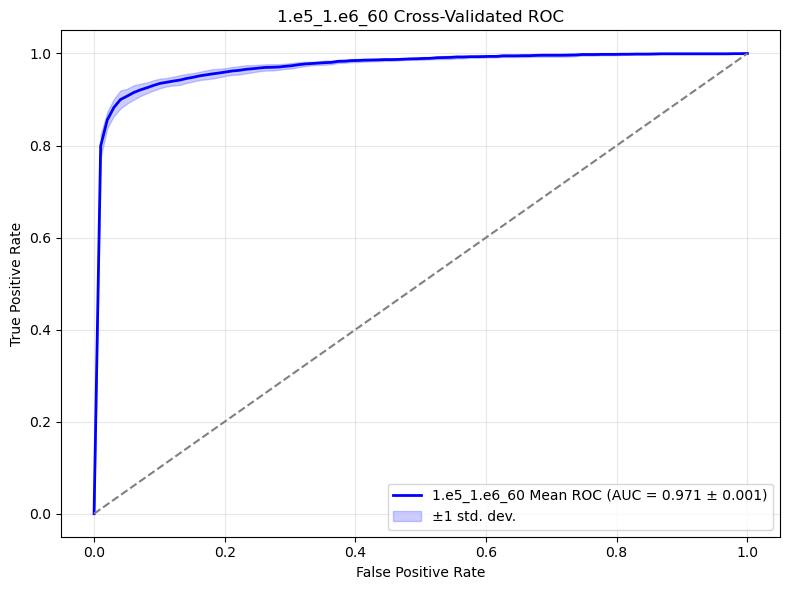

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e5_1.e6_60.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


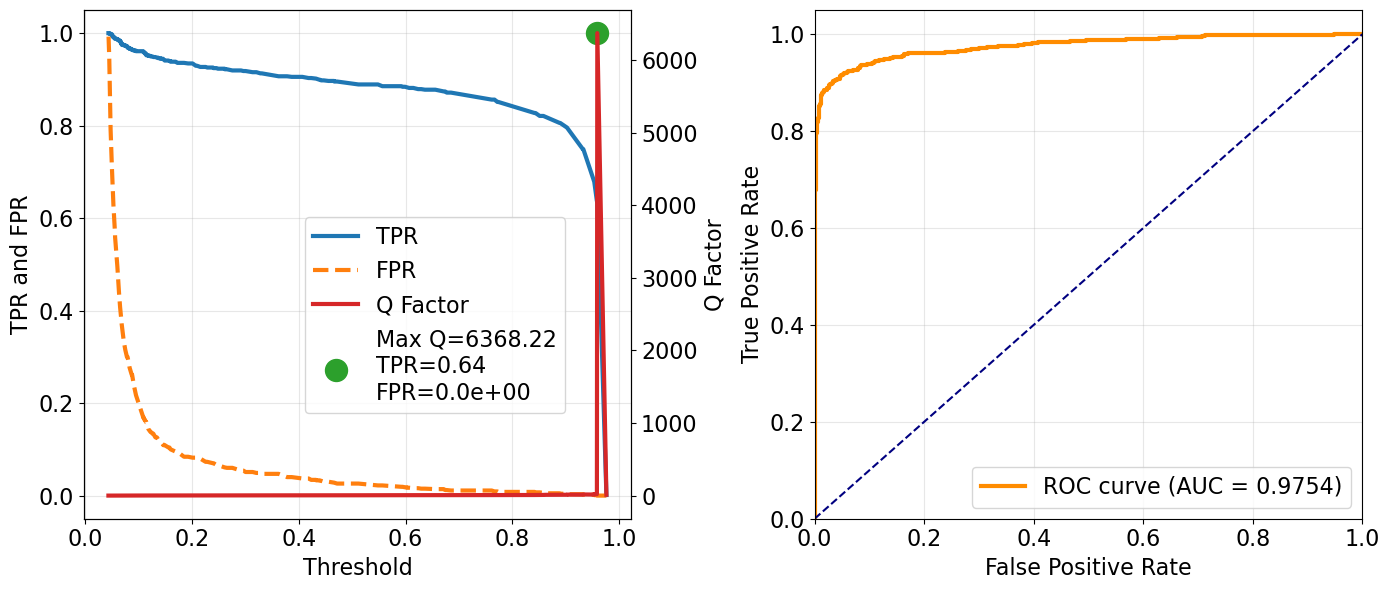

[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.976 | TPR=0.001 | FPR=0.000e+00 | Q=12.61 | Sig=9811.12
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.959 | TPR=0.637 | FPR=0.000e+00 | Q=6368.22 | Sig=4954613.64
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.958 | TPR=0.637 | FPR=1.000e-03 | Q=20.14 | Sig=3.92
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.953 | TPR=0.678 | FPR=1.000e-03 | Q=21.45 | Sig=4.18
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.953 | TPR=0.678 | FPR=2.000e-03 | Q=15.17 | Sig=2.95
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.933 | TPR=0.749 | FPR=2.000e-03 | Q=16.75 | Sig=3.26
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.932 | TPR=0.749 | FPR=3.000e-03 | Q=13.68 | Sig=2.66
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.902 | TPR=0.796 | FPR=3.000e-03 | Q=14.53 | Sig=2.83
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.902 | TPR=0.796 | FPR=4.000e-03 | Q=12.58 | Sig=2.45
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.889 | TPR=0.806 | FPR=4.000e-03 | Q=12.74 | Sig=2.48
[HIGH Q/TPR] 1.e5_1.e6_60 | Threshold=0.888 | TPR=0.806 | F

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[CV] Fold train AUC: 0.980380


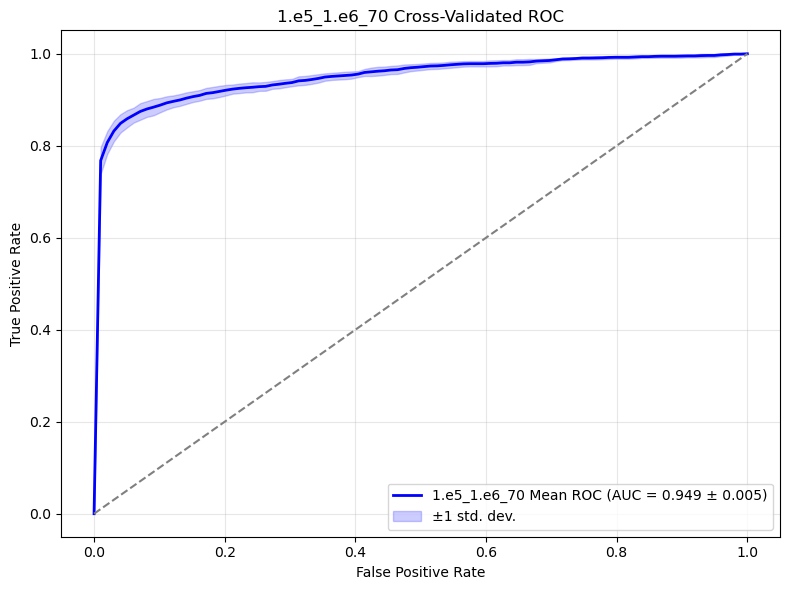

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e5_1.e6_70.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


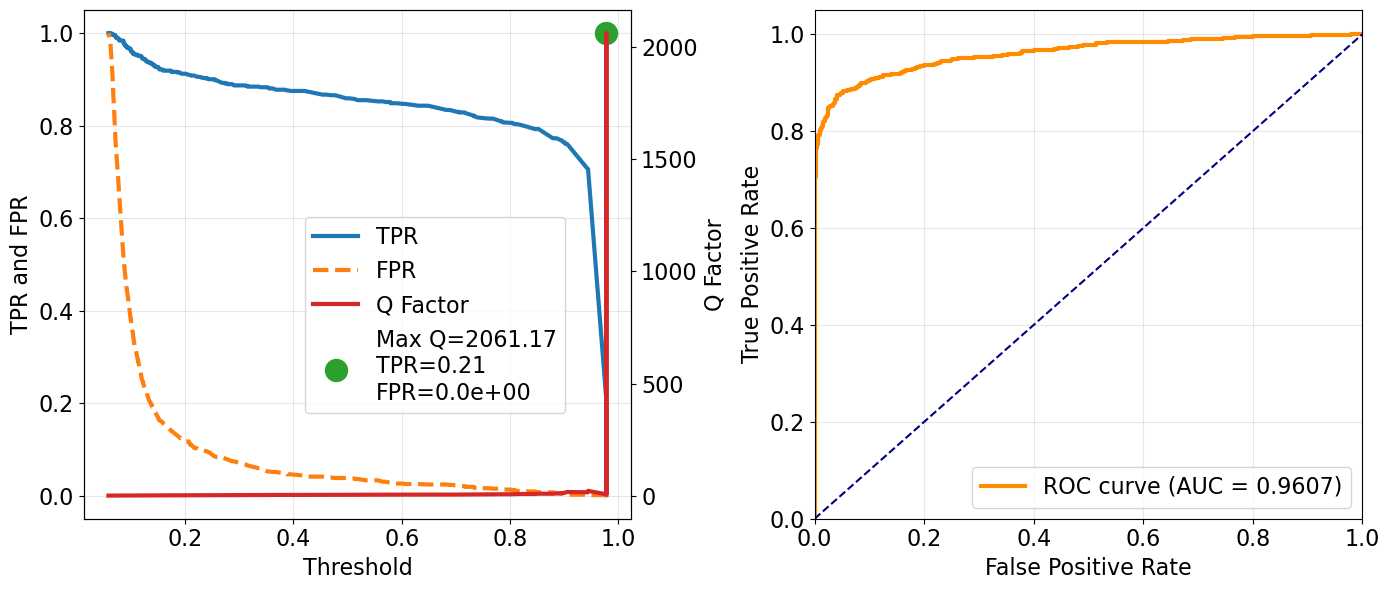

[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.978 | TPR=0.001 | FPR=0.000e+00 | Q=13.30 | Sig=7679.11
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.978 | TPR=0.206 | FPR=0.000e+00 | Q=2061.17 | Sig=1190261.33
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.978 | TPR=0.206 | FPR=1.001e-03 | Q=6.51 | Sig=1.09
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.944 | TPR=0.706 | FPR=1.001e-03 | Q=22.32 | Sig=3.74
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.944 | TPR=0.706 | FPR=2.002e-03 | Q=15.78 | Sig=2.65
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.905 | TPR=0.761 | FPR=2.002e-03 | Q=17.00 | Sig=2.85
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.902 | TPR=0.761 | FPR=3.003e-03 | Q=13.88 | Sig=2.33
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.900 | TPR=0.765 | FPR=3.003e-03 | Q=13.95 | Sig=2.34
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.899 | TPR=0.765 | FPR=4.004e-03 | Q=12.08 | Sig=2.03
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.895 | TPR=0.769 | FPR=4.004e-03 | Q=12.15 | Sig=2.04
[HIGH Q/TPR] 1.e5_1.e6_70 | Threshold=0.893 | TPR=0.769 | FP

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


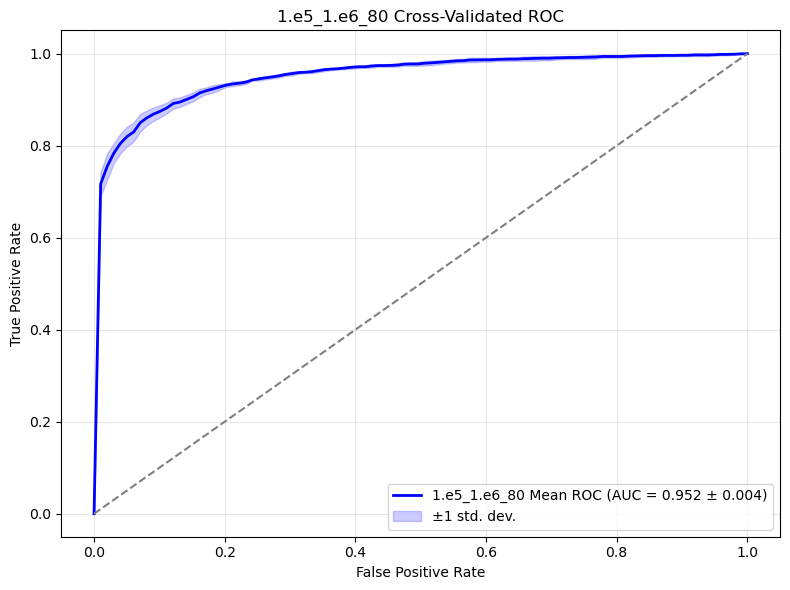

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e5_1.e6_80.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


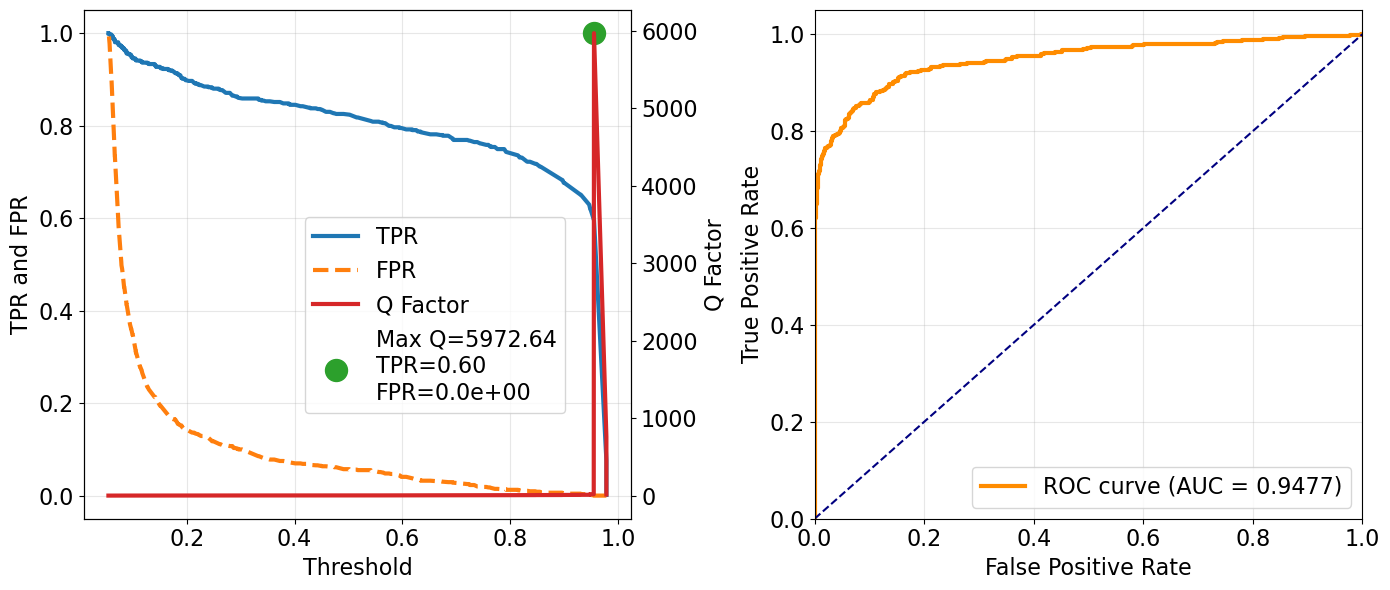

[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.979 | TPR=0.002 | FPR=0.000e+00 | Q=15.20 | Sig=4669.68
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.979 | TPR=0.073 | FPR=0.000e+00 | Q=729.48 | Sig=224144.45
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.979 | TPR=0.076 | FPR=0.000e+00 | Q=759.88 | Sig=233483.81
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.956 | TPR=0.597 | FPR=0.000e+00 | Q=5972.64 | Sig=1835182.72
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.955 | TPR=0.597 | FPR=1.040e-03 | Q=18.52 | Sig=2.27
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.949 | TPR=0.620 | FPR=1.040e-03 | Q=19.23 | Sig=2.35
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.949 | TPR=0.620 | FPR=2.079e-03 | Q=13.60 | Sig=1.66
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.947 | TPR=0.629 | FPR=2.079e-03 | Q=13.80 | Sig=1.69
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.947 | TPR=0.629 | FPR=3.119e-03 | Q=11.27 | Sig=1.38
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.931 | TPR=0.650 | FPR=3.119e-03 | Q=11.65 | Sig=1.43
[HIGH Q/TPR] 1.e5_1.e6_80 | Threshold=0.931 | T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


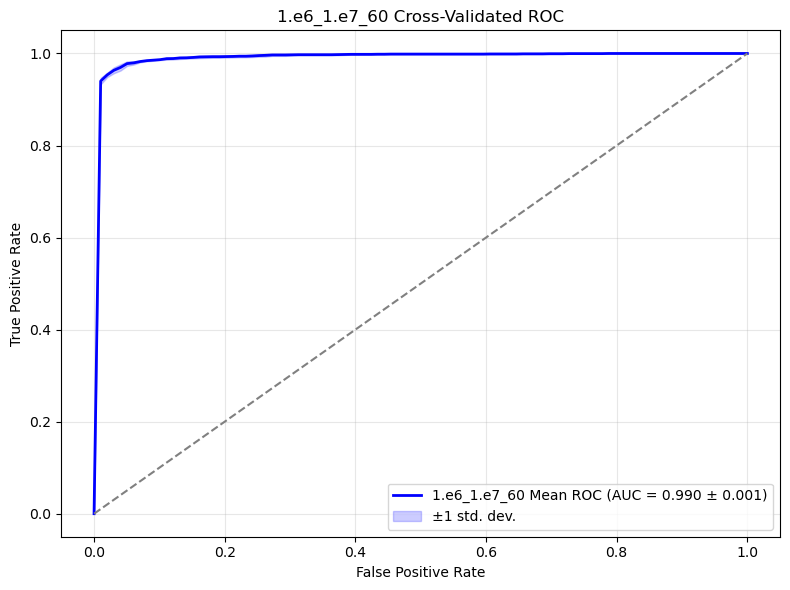

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e6_1.e7_60.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


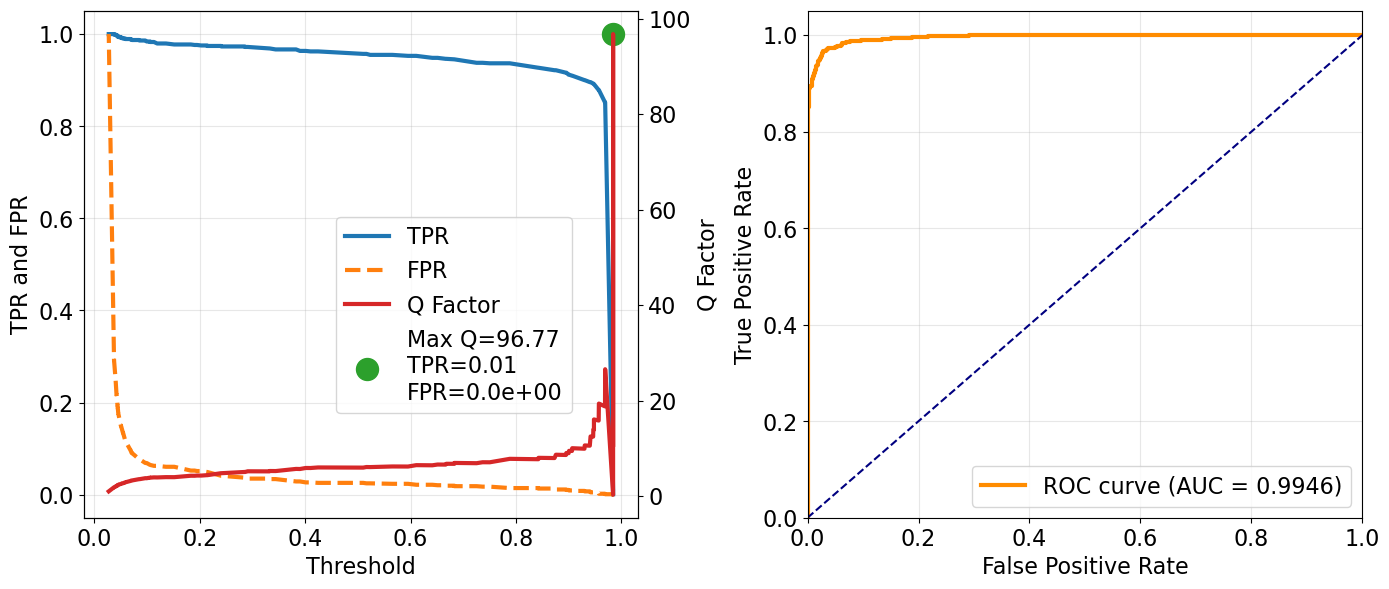

[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.984 | TPR=0.001 | FPR=0.000e+00 | Q=10.75 | Sig=252.64
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.984 | TPR=0.010 | FPR=0.000e+00 | Q=96.77 | Sig=2273.79
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.969 | TPR=0.852 | FPR=1.027e-03 | Q=26.58 | Sig=1.24
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.969 | TPR=0.852 | FPR=2.053e-03 | Q=18.79 | Sig=0.87
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.957 | TPR=0.878 | FPR=2.053e-03 | Q=19.39 | Sig=0.90
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.957 | TPR=0.878 | FPR=3.080e-03 | Q=15.83 | Sig=0.74
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.948 | TPR=0.891 | FPR=3.080e-03 | Q=16.06 | Sig=0.75
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.948 | TPR=0.891 | FPR=4.107e-03 | Q=13.91 | Sig=0.65
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.947 | TPR=0.892 | FPR=4.107e-03 | Q=13.93 | Sig=0.65
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.947 | TPR=0.892 | FPR=5.133e-03 | Q=12.46 | Sig=0.58
[HIGH Q/TPR] 1.e6_1.e7_60 | Threshold=0.942 | TPR=0.896 | FPR=5.1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


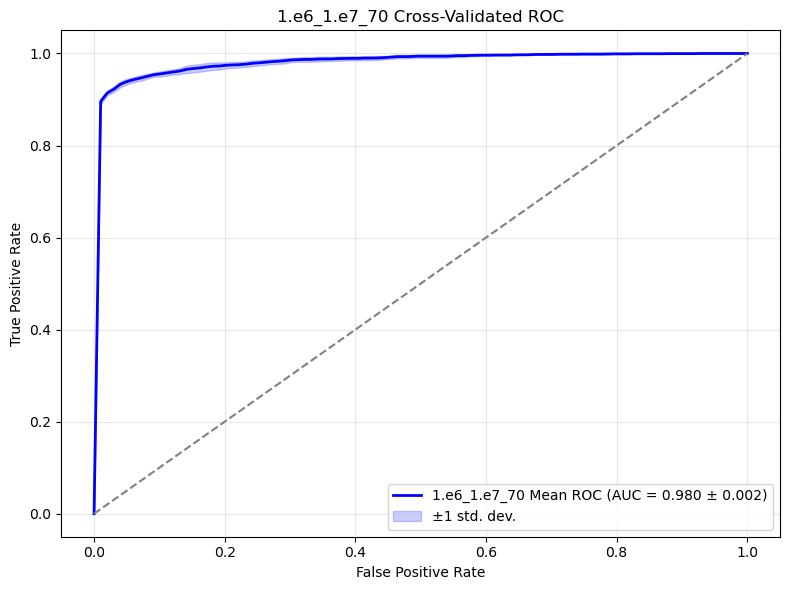

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e6_1.e7_70.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


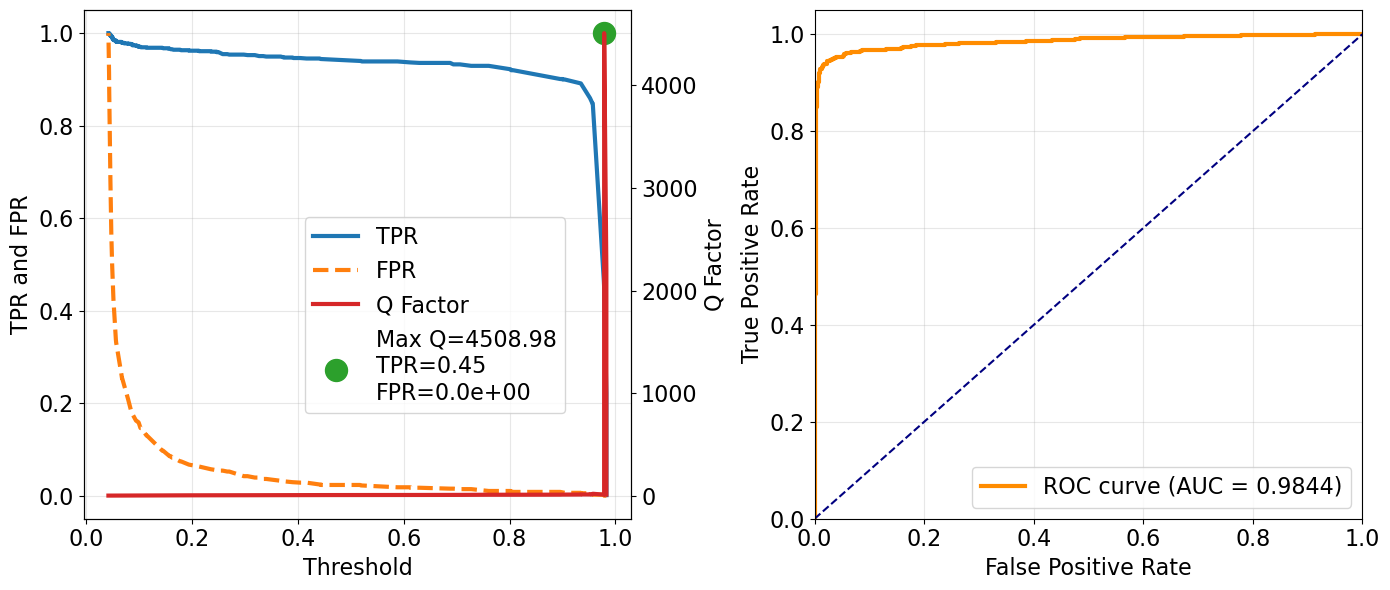

[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.983 | TPR=0.001 | FPR=0.000e+00 | Q=10.56 | Sig=184.15
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.983 | TPR=0.219 | FPR=0.000e+00 | Q=2185.85 | Sig=38119.64
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.983 | TPR=0.221 | FPR=0.000e+00 | Q=2206.97 | Sig=38487.95
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.979 | TPR=0.451 | FPR=0.000e+00 | Q=4508.98 | Sig=78633.28
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.979 | TPR=0.451 | FPR=1.000e-03 | Q=14.26 | Sig=0.57
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.978 | TPR=0.465 | FPR=1.000e-03 | Q=14.69 | Sig=0.59
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.978 | TPR=0.465 | FPR=2.000e-03 | Q=10.39 | Sig=0.42
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.957 | TPR=0.848 | FPR=2.000e-03 | Q=18.96 | Sig=0.76
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.957 | TPR=0.848 | FPR=3.000e-03 | Q=15.48 | Sig=0.62
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.956 | TPR=0.849 | FPR=3.000e-03 | Q=15.50 | Sig=0.62
[HIGH Q/TPR] 1.e6_1.e7_70 | Threshold=0.956 | TPR=

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


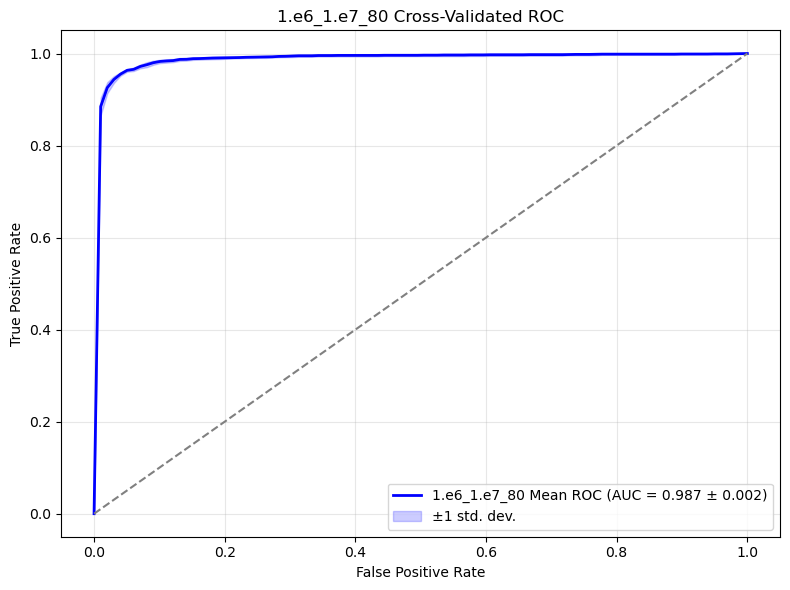

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e6_1.e7_80.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


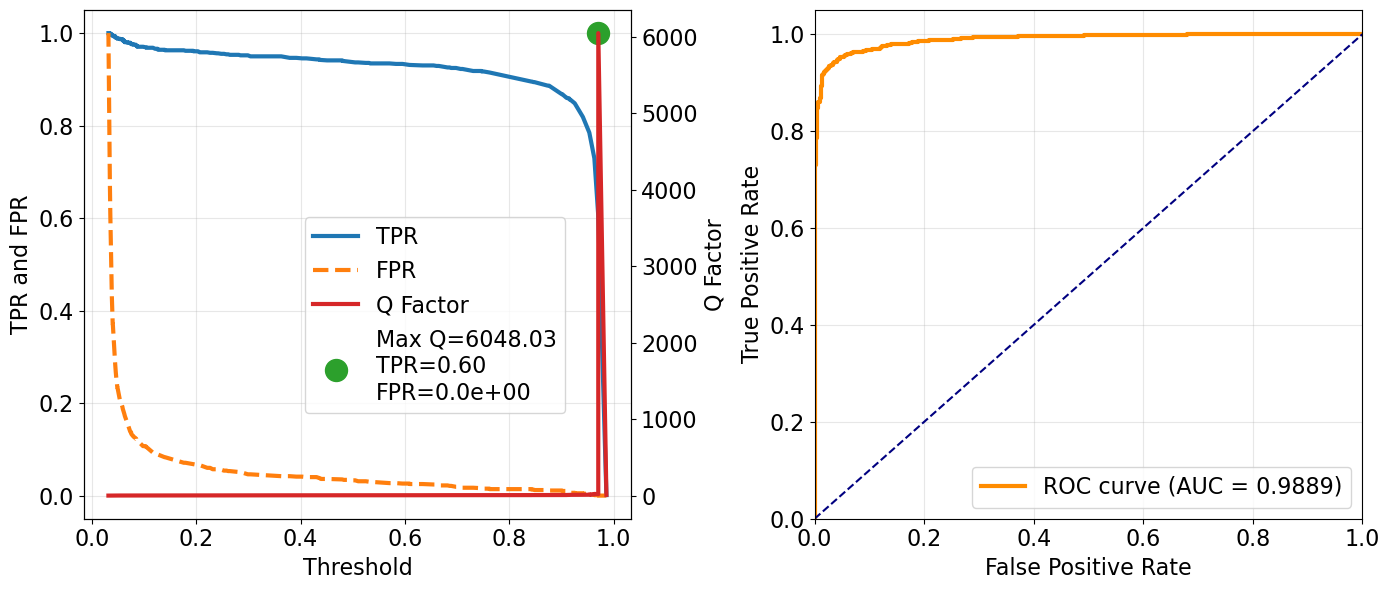

[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.986 | TPR=0.001 | FPR=0.000e+00 | Q=10.92 | Sig=101.30
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.971 | TPR=0.605 | FPR=0.000e+00 | Q=6048.03 | Sig=56121.20
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.971 | TPR=0.605 | FPR=1.000e-03 | Q=19.13 | Sig=0.56
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.963 | TPR=0.729 | FPR=1.000e-03 | Q=23.06 | Sig=0.67
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.963 | TPR=0.729 | FPR=2.000e-03 | Q=16.31 | Sig=0.48
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.957 | TPR=0.767 | FPR=2.000e-03 | Q=17.16 | Sig=0.50
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.956 | TPR=0.767 | FPR=3.000e-03 | Q=14.01 | Sig=0.41
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.954 | TPR=0.785 | FPR=3.000e-03 | Q=14.33 | Sig=0.42
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.954 | TPR=0.785 | FPR=4.000e-03 | Q=12.41 | Sig=0.36
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.941 | TPR=0.819 | FPR=4.000e-03 | Q=12.95 | Sig=0.38
[HIGH Q/TPR] 1.e6_1.e7_80 | Threshold=0.941 | TPR=0.819 | FPR=

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


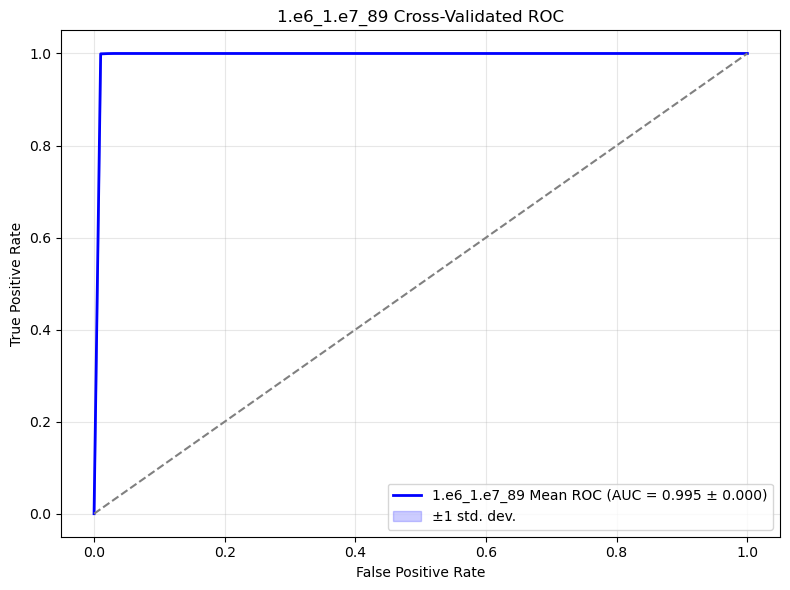

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e6_1.e7_89.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


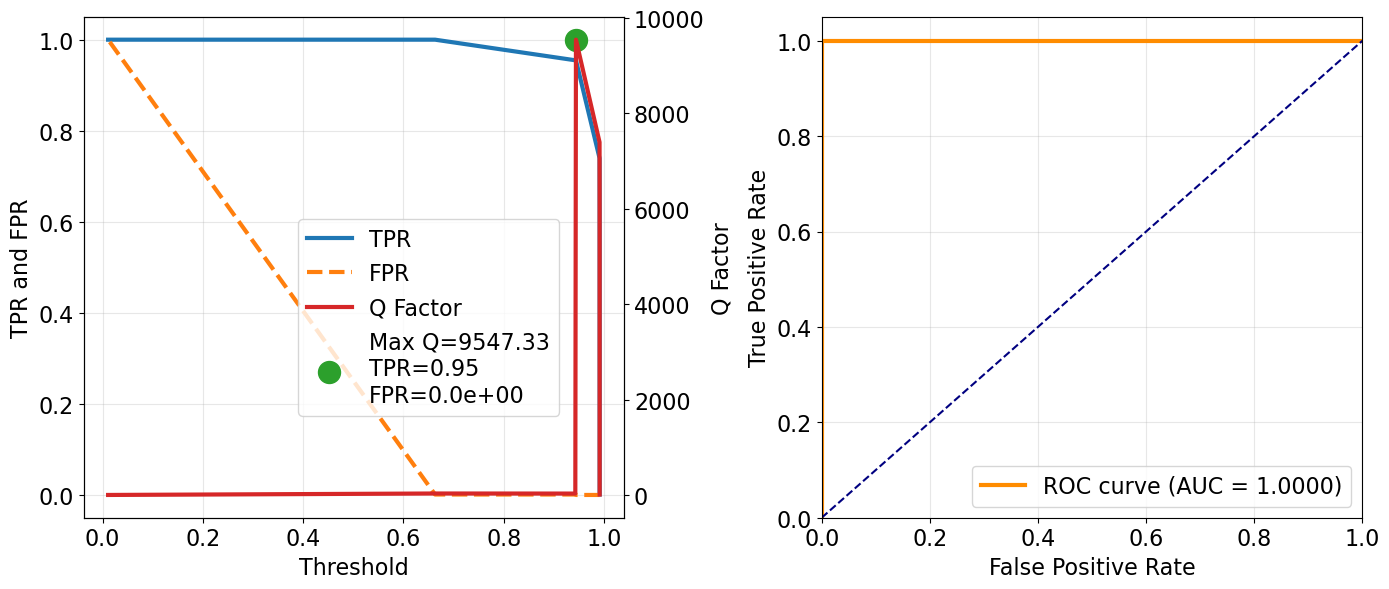

[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.001 | FPR=0.000e+00 | Q=10.29 | Sig=9.74
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.014 | FPR=0.000e+00 | Q=144.03 | Sig=136.38
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.017 | FPR=0.000e+00 | Q=174.90 | Sig=165.60
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.050 | FPR=0.000e+00 | Q=504.12 | Sig=477.32
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.056 | FPR=0.000e+00 | Q=555.56 | Sig=526.03
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.057 | FPR=0.000e+00 | Q=565.84 | Sig=535.77
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.060 | FPR=0.000e+00 | Q=596.71 | Sig=564.99
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.062 | FPR=0.000e+00 | Q=617.28 | Sig=584.47
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.065 | FPR=0.000e+00 | Q=648.15 | Sig=613.70
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991 | TPR=0.076 | FPR=0.000e+00 | Q=761.32 | Sig=720.85
[HIGH Q/TPR] 1.e6_1.e7_89 | Threshold=0.991

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


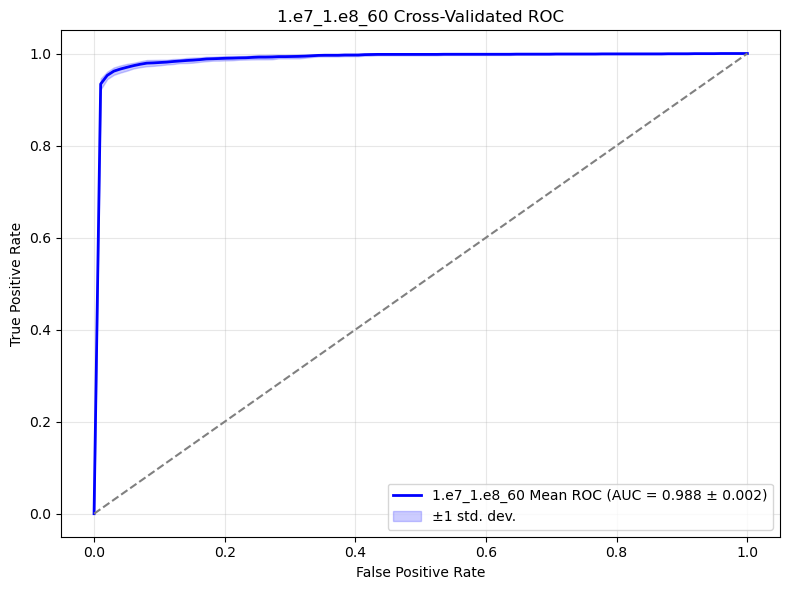

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e7_1.e8_60.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


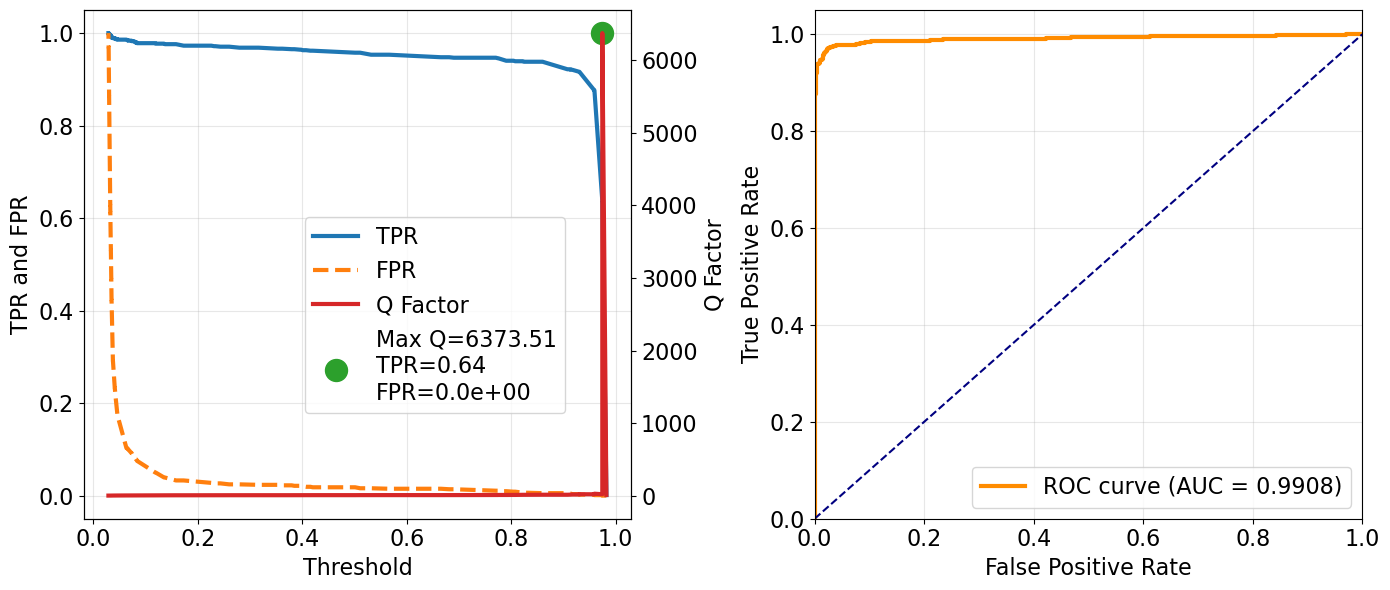

[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.982 | TPR=0.001 | FPR=0.000e+00 | Q=10.86 | Sig=7.70
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.975 | TPR=0.637 | FPR=0.000e+00 | Q=6373.51 | Sig=4522.41
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.975 | TPR=0.637 | FPR=1.057e-03 | Q=19.60 | Sig=0.41
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.959 | TPR=0.876 | FPR=1.057e-03 | Q=26.95 | Sig=0.57
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.959 | TPR=0.876 | FPR=2.114e-03 | Q=19.06 | Sig=0.40
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.931 | TPR=0.916 | FPR=2.114e-03 | Q=19.93 | Sig=0.42
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.930 | TPR=0.916 | FPR=3.171e-03 | Q=16.27 | Sig=0.34
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.917 | TPR=0.921 | FPR=3.171e-03 | Q=16.35 | Sig=0.35
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.914 | TPR=0.921 | FPR=4.228e-03 | Q=14.16 | Sig=0.30
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.913 | TPR=0.922 | FPR=4.228e-03 | Q=14.18 | Sig=0.30
[HIGH Q/TPR] 1.e7_1.e8_60 | Threshold=0.908 | TPR=0.922 | FPR=5.2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


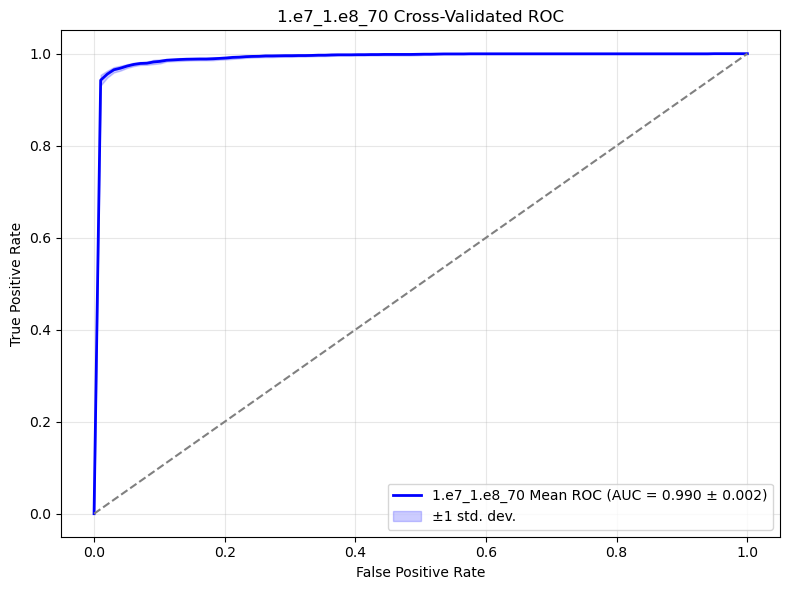

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e7_1.e8_70.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


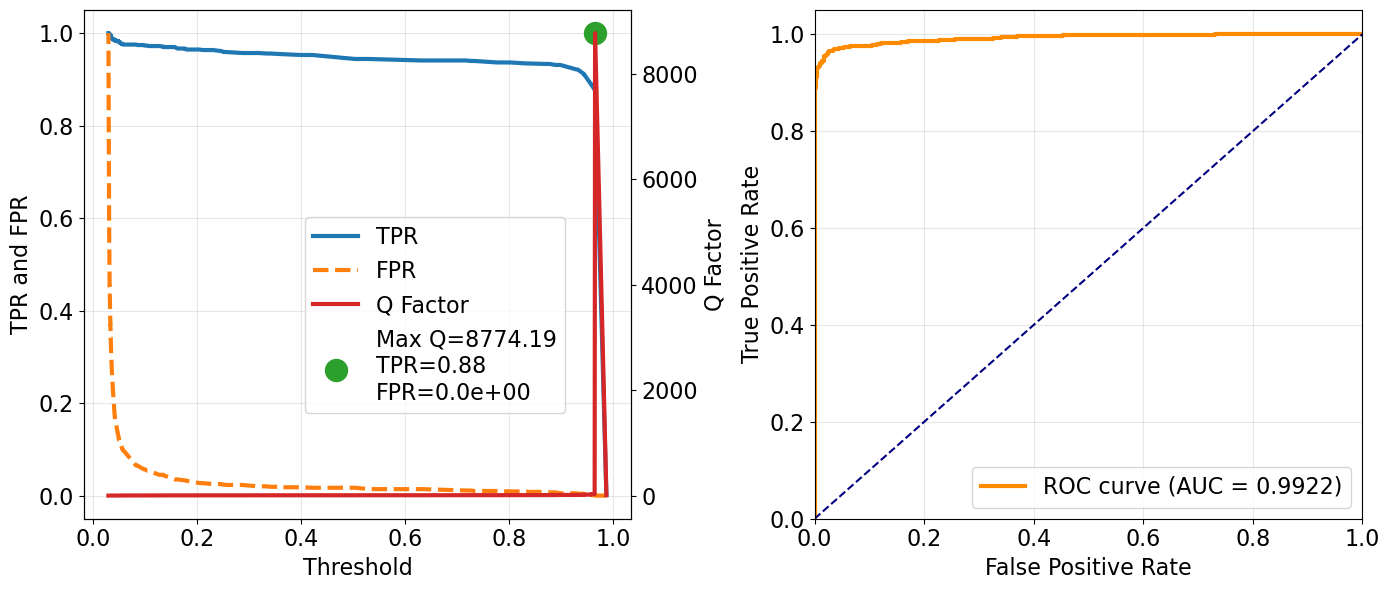

[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.987 | TPR=0.001 | FPR=0.000e+00 | Q=10.75 | Sig=5.66
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.965 | TPR=0.877 | FPR=0.000e+00 | Q=8774.19 | Sig=4621.00
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.964 | TPR=0.877 | FPR=1.000e-03 | Q=27.75 | Sig=0.51
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.958 | TPR=0.889 | FPR=1.000e-03 | Q=28.12 | Sig=0.51
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.957 | TPR=0.889 | FPR=2.000e-03 | Q=19.88 | Sig=0.36
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.945 | TPR=0.910 | FPR=2.000e-03 | Q=20.34 | Sig=0.37
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.944 | TPR=0.910 | FPR=3.000e-03 | Q=16.61 | Sig=0.30
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.944 | TPR=0.912 | FPR=3.000e-03 | Q=16.65 | Sig=0.30
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.943 | TPR=0.912 | FPR=4.000e-03 | Q=14.42 | Sig=0.26
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.931 | TPR=0.922 | FPR=4.000e-03 | Q=14.57 | Sig=0.27
[HIGH Q/TPR] 1.e7_1.e8_70 | Threshold=0.929 | TPR=0.922 | FPR=5.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


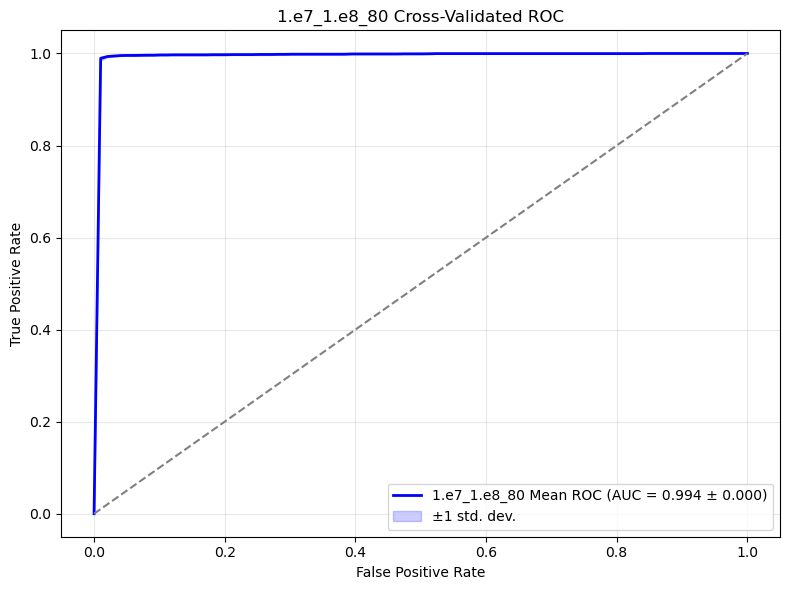

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e7_1.e8_80.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


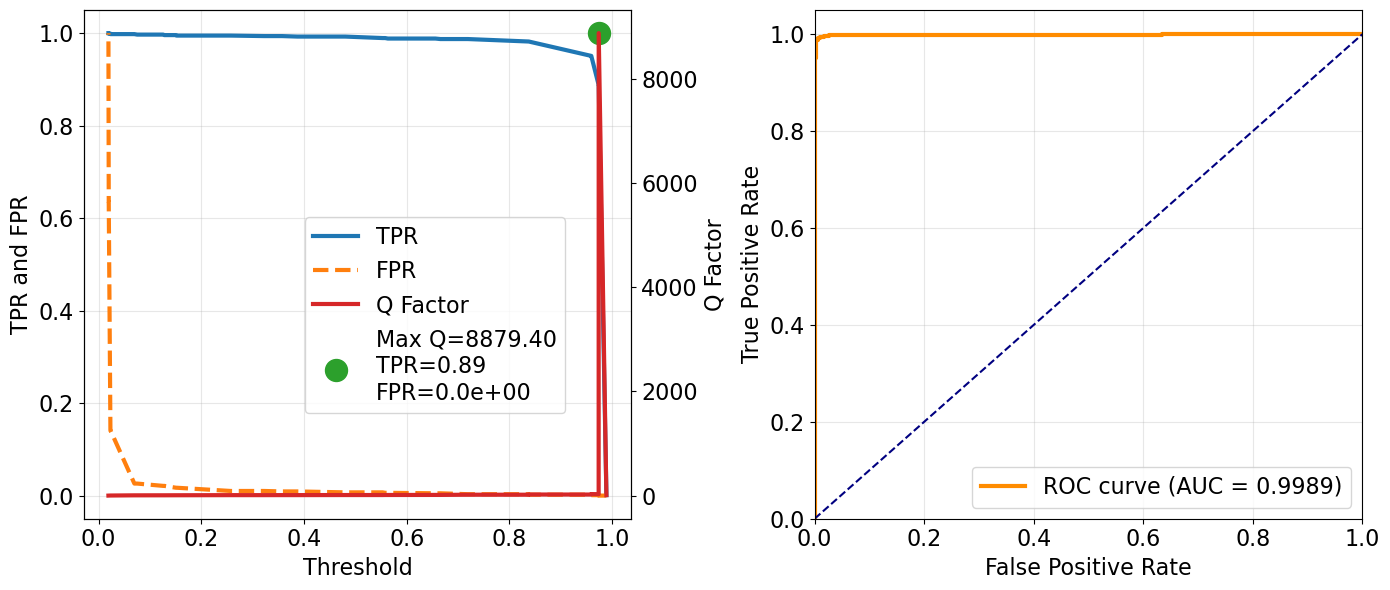

[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.989 | TPR=0.001 | FPR=0.000e+00 | Q=10.67 | Sig=2.99
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.974 | TPR=0.888 | FPR=0.000e+00 | Q=8879.40 | Sig=2488.27
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.974 | TPR=0.888 | FPR=1.000e-03 | Q=28.08 | Sig=0.37
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.959 | TPR=0.951 | FPR=1.000e-03 | Q=30.07 | Sig=0.40
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.959 | TPR=0.951 | FPR=2.000e-03 | Q=21.26 | Sig=0.28
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.838 | TPR=0.982 | FPR=2.000e-03 | Q=21.95 | Sig=0.29
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.838 | TPR=0.982 | FPR=3.000e-03 | Q=17.93 | Sig=0.24
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.719 | TPR=0.987 | FPR=3.000e-03 | Q=18.02 | Sig=0.24
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.666 | TPR=0.987 | FPR=5.000e-03 | Q=13.96 | Sig=0.19
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.656 | TPR=0.988 | FPR=5.000e-03 | Q=13.98 | Sig=0.19
[HIGH Q/TPR] 1.e7_1.e8_80 | Threshold=0.563 | TPR=0.988 | FPR=6.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


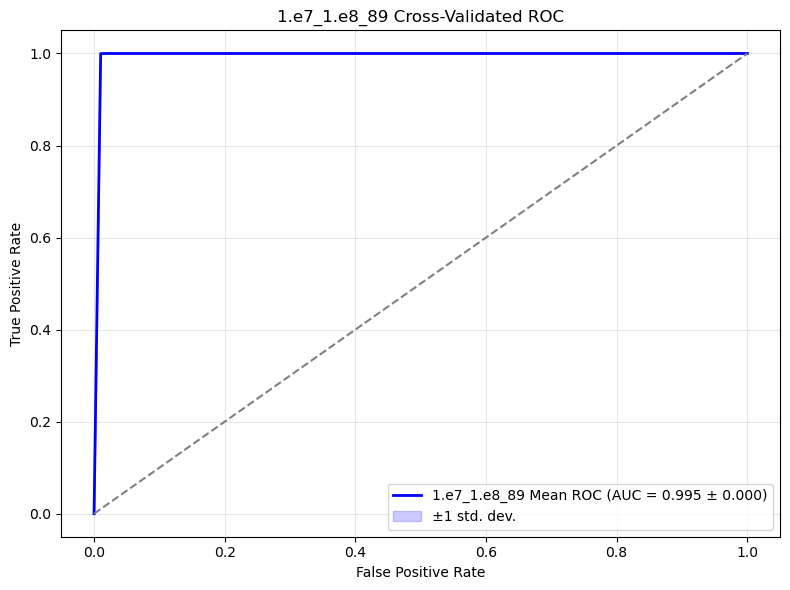

📄 每折 AUC 已保存至：./stacking_rf_svm_xgb_results_multifeature\crossval_detail_1.e7_1.e8_89.csv


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


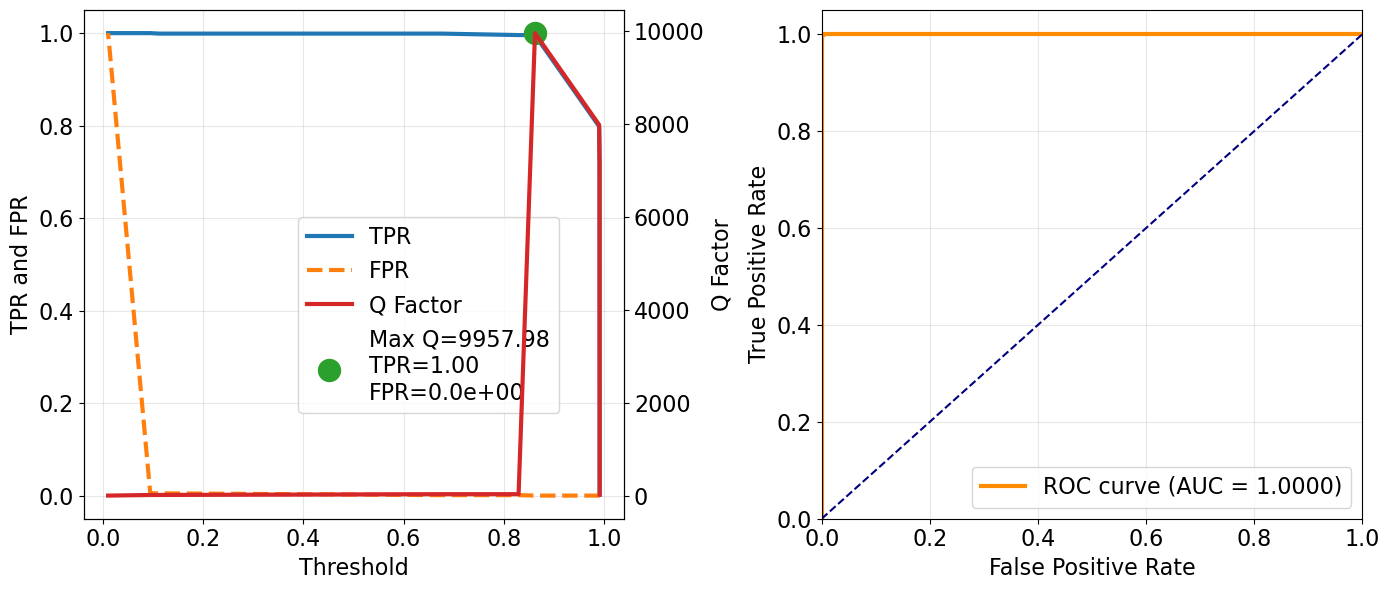

[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.002 | FPR=0.000e+00 | Q=21.01 | Sig=0.60
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.019 | FPR=0.000e+00 | Q=189.08 | Sig=5.41
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.021 | FPR=0.000e+00 | Q=210.08 | Sig=6.01
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.032 | FPR=0.000e+00 | Q=315.13 | Sig=9.01
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.133 | FPR=0.000e+00 | Q=1334.03 | Sig=38.15
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.138 | FPR=0.000e+00 | Q=1376.05 | Sig=39.35
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.151 | FPR=0.000e+00 | Q=1512.61 | Sig=43.25
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.152 | FPR=0.000e+00 | Q=1523.11 | Sig=43.55
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.154 | FPR=0.000e+00 | Q=1544.12 | Sig=44.15
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR=0.158 | FPR=0.000e+00 | Q=1575.63 | Sig=45.05
[HIGH Q/TPR] 1.e7_1.e8_89 | Threshold=0.991 | TPR

In [2]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, f1_score

# 使用示例部分
if __name__ == "__main__":
    proton_dir = r"F:\\FanWork\\PythonCode\\OnlyCorsika\\OnlyCorsika机器学习\\StackNow\\特征量txt原始数据\\质子1-5000"  
    neutrino_dir = r"F:\\FanWork\\PythonCode\\OnlyCorsika\\OnlyCorsika机器学习\\StackNow\\特征量txt原始数据\\中微子1-5000"
    output_dir = "./stacking_rf_svm_xgb_results_multifeature"

    energy_ranges = [
        "1.e5_1.e6_60", "1.e5_1.e6_70", "1.e5_1.e6_80",
        "1.e6_1.e7_60", "1.e6_1.e7_70", "1.e6_1.e7_80", "1.e6_1.e7_89",
        "1.e7_1.e8_60", "1.e7_1.e8_70", "1.e7_1.e8_80", "1.e7_1.e8_89"
    ]

    feature_list = [
        's_e', 'esize', 's_m', 'msize', 'log10_NeNm_0_600',
        'e_mean_0_600', 'e_var_0_600', 'e_skew_0_600', 'e_kurt_0_600',
        'm_mean_0_600', 'm_var_0_600', 'm_skew_0_600', 'm_kurt_0_600'
    ]

    use_gpu = True  # 设置为False如果系统没有GPU

    pipeline = StackingClassifierPipeline(
        feature_names=feature_list,
        output_dir=output_dir,
        use_gpu=use_gpu
    )

    print(f"[SYSTEM] 开始并行处理 {len(energy_ranges)} 个能段...")
    print(f"[INFO] 输出目录：{output_dir}")
    print(f"[INFO] 使用特征数：{len(feature_list)}")
    print(f"[INFO] 是否使用GPU：{use_gpu}")

    for erange in energy_ranges:
        print(f"\n[INFO] 处理能段：{erange}")
        file_p = os.path.join(proton_dir, f"{erange}_feature.txt")
        file_n = os.path.join(neutrino_dir, f"{erange}_feature.txt")
        X, y = pipeline.load_data(file_p, file_n)
        if X is not None:
            pipeline.train_and_evaluate(X, y, erange)

    pipeline.save_summary()
    print("✅ 所有能段处理完成！")


计算进度: 1/24 (能量段: 1.e5-1.e6, 角度: 60°, 能量: 1.0e+05 GeV)
计算进度: 2/24 (能量段: 1.e5-1.e6, 角度: 60°, 能量: 1.0e+06 GeV)
计算进度: 3/24 (能量段: 1.e5-1.e6, 角度: 70°, 能量: 1.0e+05 GeV)
计算进度: 4/24 (能量段: 1.e5-1.e6, 角度: 70°, 能量: 1.0e+06 GeV)
计算进度: 5/24 (能量段: 1.e5-1.e6, 角度: 80°, 能量: 1.0e+05 GeV)
计算进度: 6/24 (能量段: 1.e5-1.e6, 角度: 80°, 能量: 1.0e+06 GeV)
计算进度: 7/24 (能量段: 1.e5-1.e6, 角度: 89°, 能量: 1.0e+05 GeV)
计算进度: 8/24 (能量段: 1.e5-1.e6, 角度: 89°, 能量: 1.0e+06 GeV)
计算进度: 9/24 (能量段: 1.e6-1.e7, 角度: 60°, 能量: 1.0e+06 GeV)
计算进度: 10/24 (能量段: 1.e6-1.e7, 角度: 60°, 能量: 1.0e+07 GeV)
计算进度: 11/24 (能量段: 1.e6-1.e7, 角度: 70°, 能量: 1.0e+06 GeV)
计算进度: 12/24 (能量段: 1.e6-1.e7, 角度: 70°, 能量: 1.0e+07 GeV)
计算进度: 13/24 (能量段: 1.e6-1.e7, 角度: 80°, 能量: 1.0e+06 GeV)
计算进度: 14/24 (能量段: 1.e6-1.e7, 角度: 80°, 能量: 1.0e+07 GeV)
计算进度: 15/24 (能量段: 1.e6-1.e7, 角度: 89°, 能量: 1.0e+06 GeV)
计算进度: 16/24 (能量段: 1.e6-1.e7, 角度: 89°, 能量: 1.0e+07 GeV)
计算进度: 17/24 (能量段: 1.e7-1.e8, 角度: 60°, 能量: 1.0e+07 GeV)
计算进度: 18/24 (能量段: 1.e7-1.e8, 角度: 60°, 能量: 1.0e+08 GeV)
计算进度: 19/24 (能量段: 1

,EnergyAngle,Upper Limit (km),Low Energy (GeV),High Energy (GeV),Probability (Low),Probability (High),Probability Ratio (High/Low)
0,1.e5-1.e6-60,100.00,100000.0,1000000.0,8.782327e-09,2.025870e-08,2.306758
1,1.e5-1.e6-70,100.00,100000.0,1000000.0,1.273876e-08,2.938520e-08,2.306756
2,1.e5-1.e6-80,22.31,100000.0,1000000.0,2.264512e-08,5.223630e-08,2.306735
3,1.e5-1.e6-89,5.26,100000.0,1000000.0,9.949784e-09,2.295162e-08,2.306746
4,1.e6-1.e7-60,100.00,1000000.0,10000000.0,2.025870e-08,4.673166e-08,2.306745
5,1.e6-1.e7-70,100.00,1000000.0,10000000.0,2.938520e-08,6.778423e-08,2.306747
6,1.e6-1.e7-80,100.00,1000000.0,10000000.0,5.563118e-08,1.283270e-07,2.306746
7,1.e6-1.e7-89,5.69,1000000.0,10000000.0,3.453886e-08,7.967230e-08,2.306744
8,1.e7-1.e8-60,100.00,10000000.0,100000000.0,4.673166e-08,1.077981e-07,2.306746
9,1.e7-1.e8-70,100.00,10000000.0,100000000.0,6.778423e-08,1.563611e-07,2.306747


可视化结果已保存到 'neutrino_probabilities_full.png'


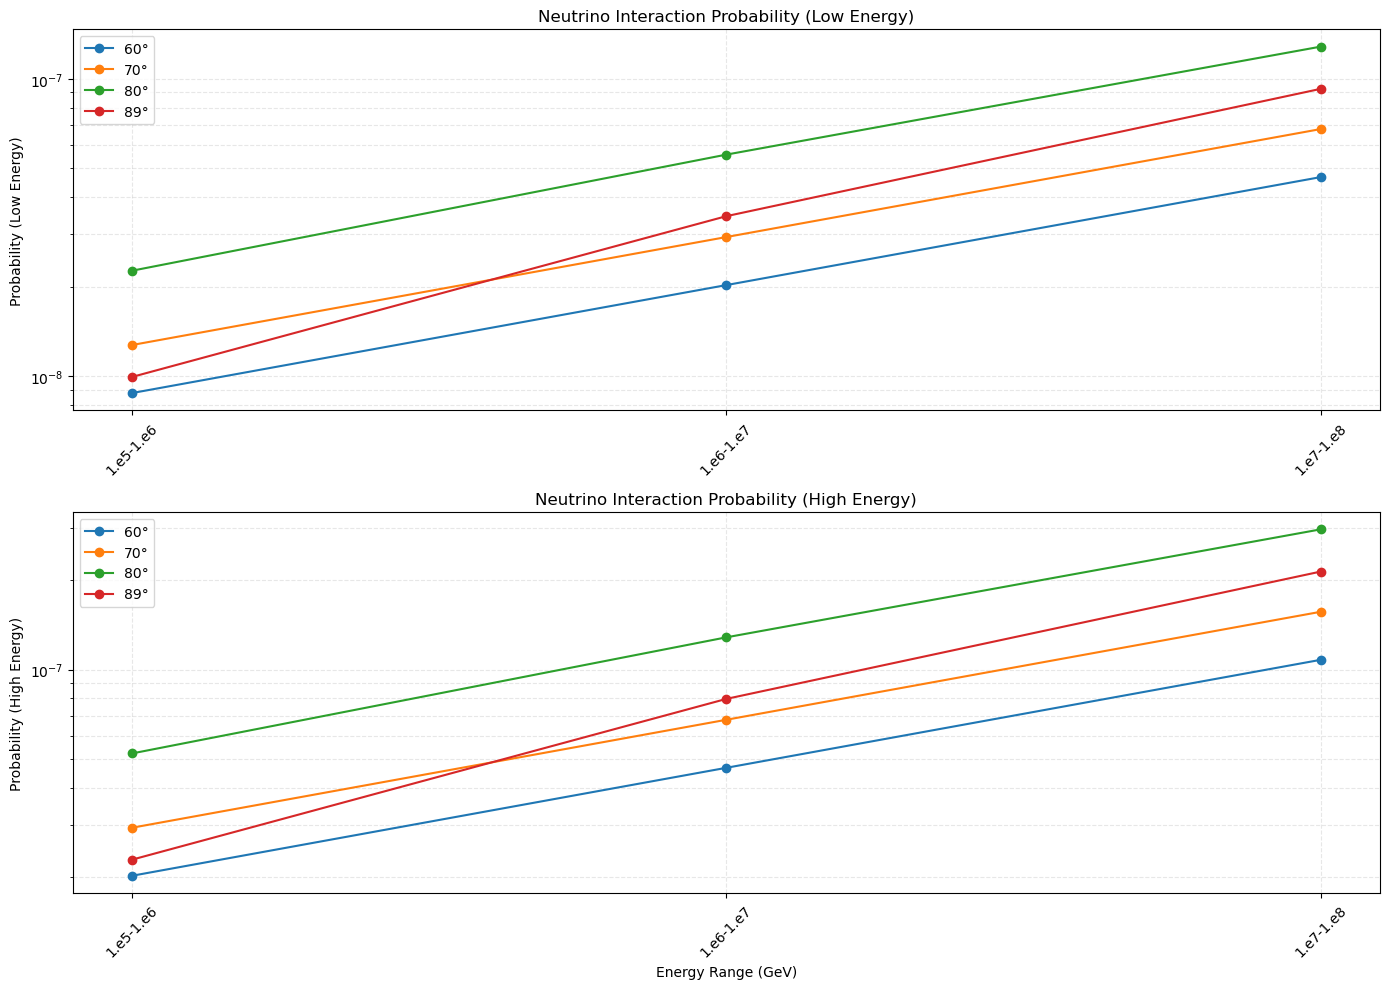

概率比可视化结果已保存到 'probability_ratio.png'


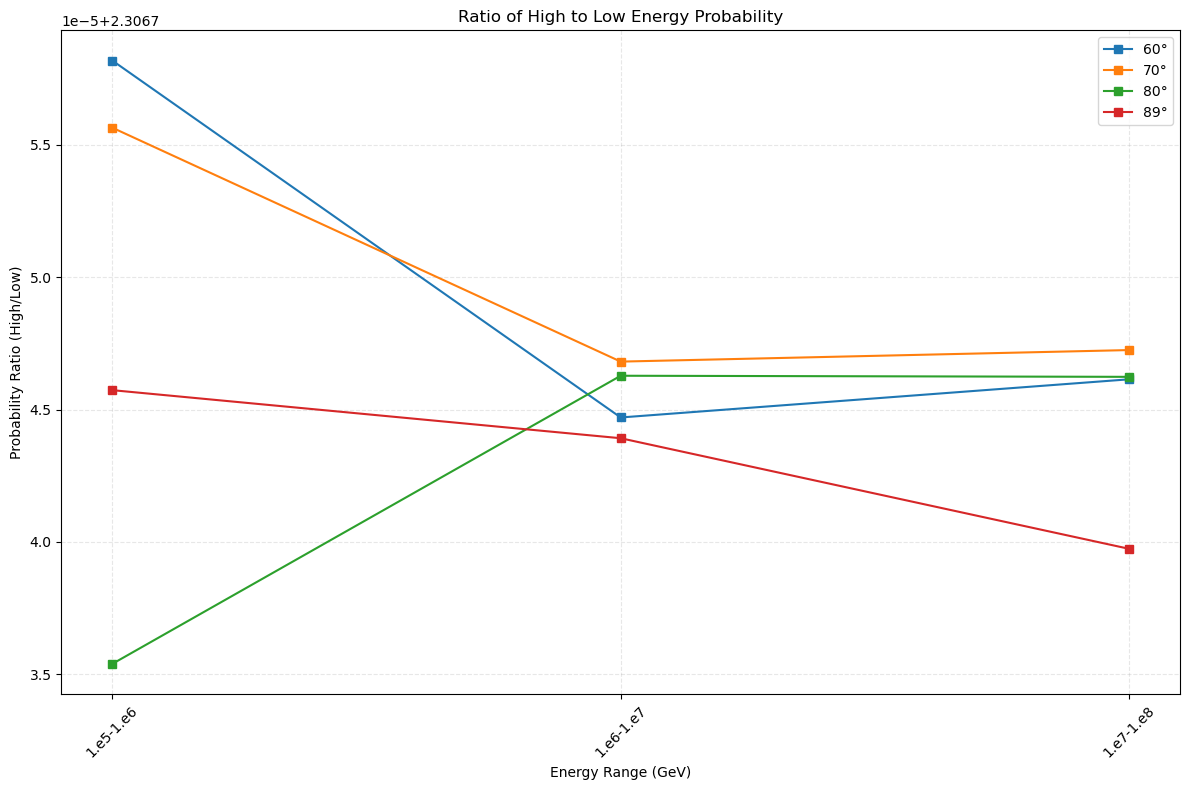

In [3]:
# 中微子概率积分
import math
import scipy.integrate as integrate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def hiePDF(hh, theta, E):
    """
    计算给定高度、角度和能量的中微子相互作用概率密度函数
    
    参数:
        hh (float): 高度 (cm)
        theta (float): 角度 (弧度)
        E (float): 能量 (GeV)
    
    返回:
        float: 概率密度值
    """
    h2 = 100.0e5  # 100 km in cm
    Re = 6371.004e5  # 地球半径 (cm)
    
    # 计算eps值
    A = 28.9634
    Na = 6.02214076e23  # 阿伏伽德罗常数
    eps = (Na / A) * (5.53e-36) * (E ** 0.363)  # E in GeV

    # 计算L2和L
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    
    term1 = cos_theta * cos_theta + 2 * sin_theta * sin_theta * h2 / Re
    term2 = cos_theta * cos_theta + 2 * sin_theta * sin_theta * hh / Re
    
    L2 = (math.sqrt(term1) - cos_theta) * Re / (sin_theta * sin_theta)
    L = (math.sqrt(term2) - cos_theta) * Re / (sin_theta * sin_theta)
    L = L2 - L

    # 将高度从cm转换为km
    hkm = hh / 1e5  # cm to km

    # 根据高度范围计算温度和压力
    if 0 < hh < 11e5:  # 0-11 km
        T = 288.15 - hkm * 6.5
        P = 1013.25 * (288.15 / T) ** (-5.256)
    elif 11e5 <= hh < 20e5:  # 11-20 km
        T = 216.65
        P = 226.31 * math.exp(1.73 - 0.1577 * hkm)
    elif 20e5 <= hh < 32e5:  # 20-32 km
        T = 196.65 + hkm
        P = 54.48 * (216.65 / T) ** 34.163
    elif 32e5 <= hh < 47e5:  # 32-47 km
        T = 139.05 + 2.8 * hkm
        P = 8.637 * (228.65 / T) ** 12.2
    elif 47e5 <= hh < 51e5:  # 47-51 km
        T = 270.65
        P = 1.10 * math.exp(5.91 - 0.1265 * hkm)
    elif 51e5 <= hh < 71e5:  # 51-71 km
        T = 413.45 - 2.8 * hkm
        P = 0.64 * (270.65 / T) ** (-12.2)
    else:  # 71+ km
        T = 356.65 - 2 * hkm
        P = 0.038 * (214.65 / T) ** (-17.0815)

    # 单位转换
    P *= 100  # hPa → Pa
    rho = P / (286.9 * T)  # kg/m³
    rho *= 1e-3  # kg/m³ → g/cm³

    # 计算l_h
    term = Re * Re * cos_theta * cos_theta + 2 * Re * sin_theta * sin_theta * hh
    l_h = Re * (term ** (-0.5))

    # 计算最终的概率密度值
    PHF = math.exp(-eps * rho * L) * eps * rho * l_h
    return PHF

def calculate_probability(E_GeV, angle, upper_limit_km):
    """
    计算给定能量、角度和上限高度的中微子相互作用概率
    
    参数:
        E_GeV (float): 能量值 (GeV)
        angle (int): 角度值
        upper_limit_km (float): 上限高度 (km)
    
    返回:
        float: 中微子相互作用概率
    """
    # 转换角度为弧度
    theta_rad = math.radians(angle)
    
    # 转换上限高度为cm
    upper_limit_cm = upper_limit_km * 100000.0
    
    # 积分下限 (4.5 km)
    lower_limit_cm = 4.5 * 100000.0
    
    # 使用quad进行积分，设置绝对误差容限为1e-12
    integral, error = integrate.quad(
        hiePDF, 
        lower_limit_cm, 
        upper_limit_cm, 
        args=(theta_rad, E_GeV),
        epsabs=1e-12
    )
    
    return integral

def calculate_neutrino_probabilities():
    """
    计算中微子相互作用概率并返回DataFrame
    """
    # 定义要计算的数据
    energy_ranges = [
        ("1.e5-1.e6", 1e5, 1e6),
        ("1.e6-1.e7", 1e6, 1e7),
        ("1.e7-1.e8", 1e7, 1e8)
    ]
    
    angles = [60, 70, 80, 89]
    
    # 每个角度对应的上限高度
    upper_limits = {
        (60, "1.e5-1.e6"): 100,
        (70, "1.e5-1.e6"): 100,
        (80, "1.e5-1.e6"): 22.31,
        (89, "1.e5-1.e6"): 5.26,
        (60, "1.e6-1.e7"): 100,
        (70, "1.e6-1.e7"): 100,
        (80, "1.e6-1.e7"): 100,
        (89, "1.e6-1.e7"): 5.69,
        (60, "1.e7-1.e8"): 100,
        (70, "1.e7-1.e8"): 100,
        (80, "1.e7-1.e8"): 100,
        (89, "1.e7-1.e8"): 5.91
    }
    
    # 计算结果
    results = []
    total_calculations = len(energy_ranges) * len(angles) * 2  # 每个组合计算两个能量点
    calculation_count = 0
    
    for energy_range, E_low, E_high in energy_ranges:
        for angle in angles:
            # 获取当前角度和能量范围对应的上限高度
            upper_limit = upper_limits.get((angle, energy_range), 100)
            
            # 计算下限能量
            calculation_count += 1
            print(f"计算进度: {calculation_count}/{total_calculations} (能量段: {energy_range}, 角度: {angle}°, 能量: {E_low:.1e} GeV)")
            prob_low = calculate_probability(E_low, angle, upper_limit)
            
            # 计算上限能量
            calculation_count += 1
            print(f"计算进度: {calculation_count}/{total_calculations} (能量段: {energy_range}, 角度: {angle}°, 能量: {E_high:.1e} GeV)")
            prob_high = calculate_probability(E_high, angle, upper_limit)
            
            # 创建EnergyAngle列，格式为"能量段-角度deg"
            energy_angle = f"{energy_range}-{angle}"
            
            results.append({
                "EnergyAngle": energy_angle,  # 合并后的列
                "Energy Range": energy_range,  # 保留原始列用于可视化
                "Angle (deg)": angle,         # 保留原始列用于可视化
                "Upper Limit (km)": upper_limit,
                "Low Energy (GeV)": E_low,
                "High Energy (GeV)": E_high,
                "Probability (Low)": prob_low,
                "Probability (High)": prob_high,
                "Probability Ratio (High/Low)": prob_high / prob_low
            })
    
    return pd.DataFrame(results)

# 在Jupyter Notebook中运行以下代码
if __name__ == "__main__":
    # 计算概率
    df = calculate_neutrino_probabilities()
    
    # 保存到CSV - 只包含EnergyAngle列（合并列）
    csv_filename = "neutrino_probabilities_full.csv"
    
    # 创建只包含合并列和其他必要列的数据框
    df_to_save = df[["EnergyAngle", "Upper Limit (km)", "Low Energy (GeV)", 
                     "High Energy (GeV)", "Probability (Low)", 
                     "Probability (High)", "Probability Ratio (High/Low)"]]
    
    df_to_save.to_csv(csv_filename, index=False)
    print(f"\n结果已保存到 '{csv_filename}'")
    
    # 在下方打印结果
    print("\n完整计算结果:")
    print("=" * 80)
    display(df_to_save)
    
    # 可视化结果 - 下限能量概率
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 1, 1)
    
    # 按角度分组绘制下限能量概率
    for angle in [60, 70, 80, 89]:
        subset = df[df["Angle (deg)"] == angle]
        plt.plot(subset["Energy Range"], subset["Probability (Low)"], 'o-', label=f"{angle}°")
    
    plt.yscale('log')
    plt.ylabel('Probability (Low Energy)')
    plt.title('Neutrino Interaction Probability (Low Energy)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xticks(rotation=45)
    
    # 可视化结果 - 上限能量概率
    plt.subplot(2, 1, 2)
    
    # 按角度分组绘制上限能量概率
    for angle in [60, 70, 80, 89]:
        subset = df[df["Angle (deg)"] == angle]
        plt.plot(subset["Energy Range"], subset["Probability (High)"], 'o-', label=f"{angle}°")
    
    plt.yscale('log')
    plt.xlabel('Energy Range (GeV)')
    plt.ylabel('Probability (High Energy)')
    plt.title('Neutrino Interaction Probability (High Energy)')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # 保存图像
    img_filename = "neutrino_probabilities_full.png"
    plt.savefig(img_filename, dpi=300)
    print(f"可视化结果已保存到 '{img_filename}'")
    plt.show()
    
    # 额外可视化：概率比（高能/低能）
    plt.figure(figsize=(12, 8))
    
    for angle in [60, 70, 80, 89]:
        subset = df[df["Angle (deg)"] == angle]
        plt.plot(subset["Energy Range"], subset["Probability Ratio (High/Low)"], 's-', label=f"{angle}°")
    
    plt.xlabel('Energy Range (GeV)')
    plt.ylabel('Probability Ratio (High/Low)')
    plt.title('Ratio of High to Low Energy Probability')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 保存额外图像
    ratio_filename = "probability_ratio.png"
    plt.savefig(ratio_filename, dpi=300)
    print(f"概率比可视化结果已保存到 '{ratio_filename}'")
    plt.show()

In [4]:
# %% [markdown]
# # 显著性计算：多种小量情况下的 Sig 计算

# %% [code]
import pandas as pd
import numpy as np

# 读取 CSV 文件
df = pd.read_csv('./stacking_rf_svm_xgb_results_multifeature/summary.csv')

# 保留相关列
cols = ['energy_range', 'Sig_FPR', 'Sig_TPR', 'N_nu', 'N_p']
df = df[cols].copy()

# 小量列表
epsilons = [1e-8, 1e-10, 1e-12, 1e-14, 1e-16, 1e-18, 1e-20,  1e-22]

# 为每个 epsilon 添加显著性计算列
for eps in epsilons:
    col_name = f"Sig_epsilon_{int(-np.log10(eps))}"
    df[col_name] = df['Sig_TPR'] * df['N_nu'] / np.sqrt((df['Sig_FPR'] + eps) * df['N_p'])

# 保存为新的 CSV 文件
output_path = './stacking_rf_svm_xgb_results_multifeature/summary_with_significance.csv'
df.to_csv(output_path, index=False)

print(f"✅ 已保存带显著性的结果至：{output_path}")


✅ 已保存带显著性的结果至：./stacking_rf_svm_xgb_results_multifeature/summary_with_significance.csv


In [5]:
# %% [code]
import pandas as pd

# 1. 读取显著性数据
sig_df = pd.read_csv('./stacking_rf_svm_xgb_results_multifeature/summary_with_significance.csv')

# 2. 读取中微子反应概率数据
prob_df = pd.read_csv('./neutrino_probabilities_full.csv')

# 3. 统一能量范围格式（将下划线替换为短横线）
sig_df['EnergyAngle'] = sig_df['energy_range'].str.replace('_', '-')
prob_df['EnergyAngle'] = prob_df['EnergyAngle'].str.replace('-', '-')  # 确保格式一致

# 4. 合并两个表（按统一后的EnergyAngle）
merged_df = pd.merge(sig_df, prob_df[['EnergyAngle', 'Probability (Low)', 'Probability (High)']],
                     on='EnergyAngle', how='inner')

# 5. 计算真实显著性：显著性 × 概率积分
eps_cols = [col for col in merged_df.columns if col.startswith('Sig_epsilon_')]

for col in eps_cols:
    merged_df[f'{col}_real_low'] = merged_df[col] * merged_df['Probability (Low)']
    merged_df[f'{col}_real_high'] = merged_df[col] * merged_df['Probability (High)']

# 6. 保存结果到新 CSV
output_path = './stacking_rf_svm_xgb_results_multifeature/summary_with_real_significance.csv'
merged_df.to_csv(output_path, index=False)

print(f"✅ 已保存真实显著性结果到：{output_path}")
print(f"合并后的数据行数：{len(merged_df)}")
print("真实显著性计算示例（第一行 Sig_epsilon_8_real_low）：")
print(merged_df.iloc[0][['Sig_epsilon_8', 'Probability (Low)', 'Sig_epsilon_8_real_low']])

✅ 已保存真实显著性结果到：./stacking_rf_svm_xgb_results_multifeature/summary_with_real_significance.csv
合并后的数据行数：11
真实显著性计算示例（第一行 Sig_epsilon_8_real_low）：
Sig_epsilon_8             1240.026239
Probability (Low)                 0.0
Sig_epsilon_8_real_low       0.000011
Name: 0, dtype: object


Energy ranges found: ['1.e5-1.e6' '1.e6-1.e7' '1.e7-1.e8']


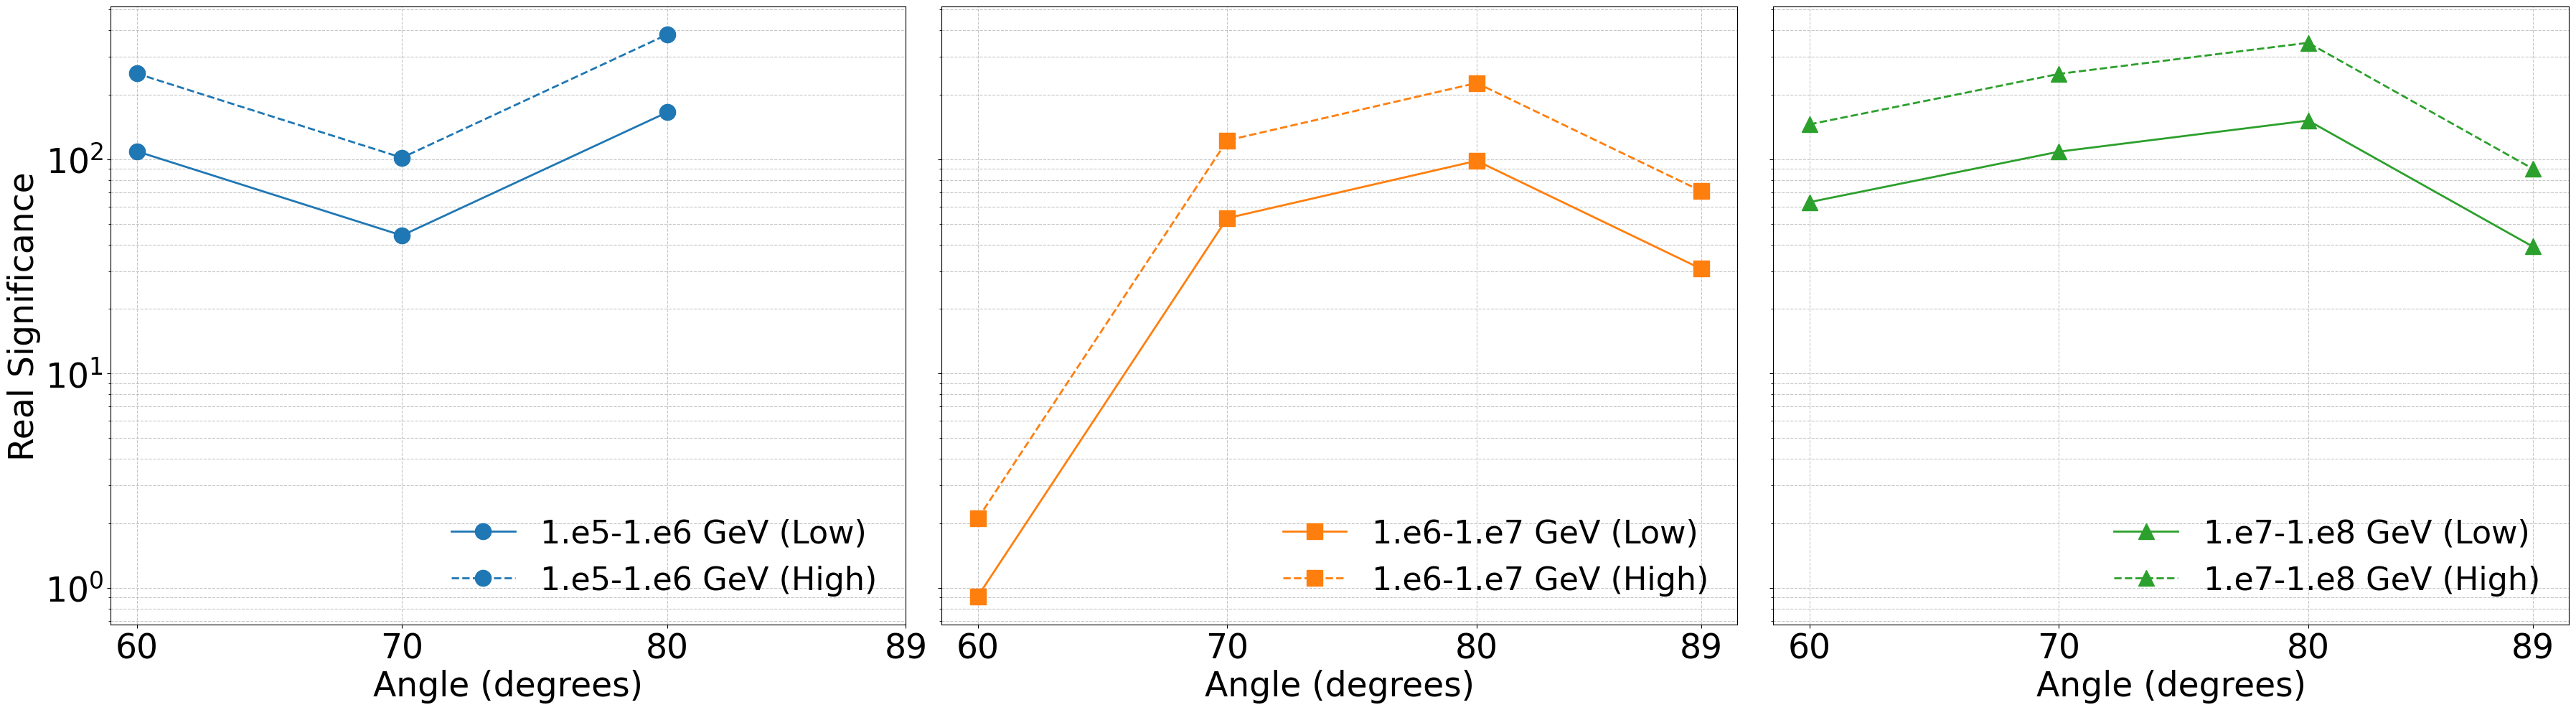

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read CSV file
df = pd.read_csv('./stacking_rf_svm_xgb_results_multifeature/summary_with_real_significance.csv')

# Extract angle information
df['angle'] = df['EnergyAngle'].str.split('-').str[-1].astype(int)

# Extract energy range information
def extract_energy_range(row):
    parts = row['EnergyAngle'].split('-')
    return f"{parts[0]}-{parts[1]}"

df['energy_range'] = df.apply(extract_energy_range, axis=1)

# Get unique energy ranges
energy_ranges = df['energy_range'].unique()
print(f"Energy ranges found: {energy_ranges}")

# Set colors and marker styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Different colors
markers = ['o', 's', '^', 'D']  # Different markers
line_styles = ['-', '--']  # Solid line for low, dashed line for high

# Create a figure with subplots (horizontal layout)
fig, axes = plt.subplots(nrows=1, ncols=len(energy_ranges), figsize=(12 * len(energy_ranges), 10), sharey=True)

# If there is only one subplot, axes is not an array, so convert it to an array
if len(energy_ranges) == 1:
    axes = [axes]

# Plot data for each energy range in separate subplots
for i, energy_range in enumerate(energy_ranges):
    subset = df[df['energy_range'] == energy_range]
    
    # Sort by angle
    subset = subset.sort_values('angle')
    
    # Plot Sig_epsilon_20_real_low
    axes[i].plot(subset['angle'], subset['Sig_epsilon_22_real_low'], 
                 label=f"{energy_range} GeV (Low)", 
                 color=colors[i], marker=markers[i], linestyle=line_styles[0], 
                 linewidth=2, markersize=16)
    
    # Plot Sig_epsilon_20_real_high
    axes[i].plot(subset['angle'], subset['Sig_epsilon_22_real_high'], 
                 label=f"{energy_range} GeV (High)", 
                 color=colors[i], marker=markers[i], linestyle=line_styles[1], 
                 linewidth=2, markersize=16)
    
    # Set y-axis to log scale
    axes[i].set_yscale('log')
    
    # Add legend (place it at the bottom right corner and remove the border)
    axes[i].legend(fontsize=32, loc='lower right', frameon=False)
    
    # Add grid
    axes[i].grid(True, which='both', linestyle='--', alpha=0.7)
    
    # Set x-axis label
    axes[i].set_xlabel('Angle (degrees)', fontsize=34)
    
    # Set y-axis label only for the first subplot
    if i == 0:
        axes[i].set_ylabel('Real Significance', fontsize=34)

# Set x-axis ticks
for ax in axes:
    ax.set_xticks([60, 70, 80, 89])
    ax.tick_params(axis='both', labelsize=34)

# Adjust layout
plt.tight_layout()

# Save the image
plt.savefig('./stacking_rf_svm_xgb_results_multifeature/significance_plot.png', dpi=800)
plt.savefig('./stacking_rf_svm_xgb_results_multifeature/significance_plot.pdf')

# Show the image
plt.show()

Energy ranges found: ['1.e5-1.e6' '1.e6-1.e7' '1.e7-1.e8']


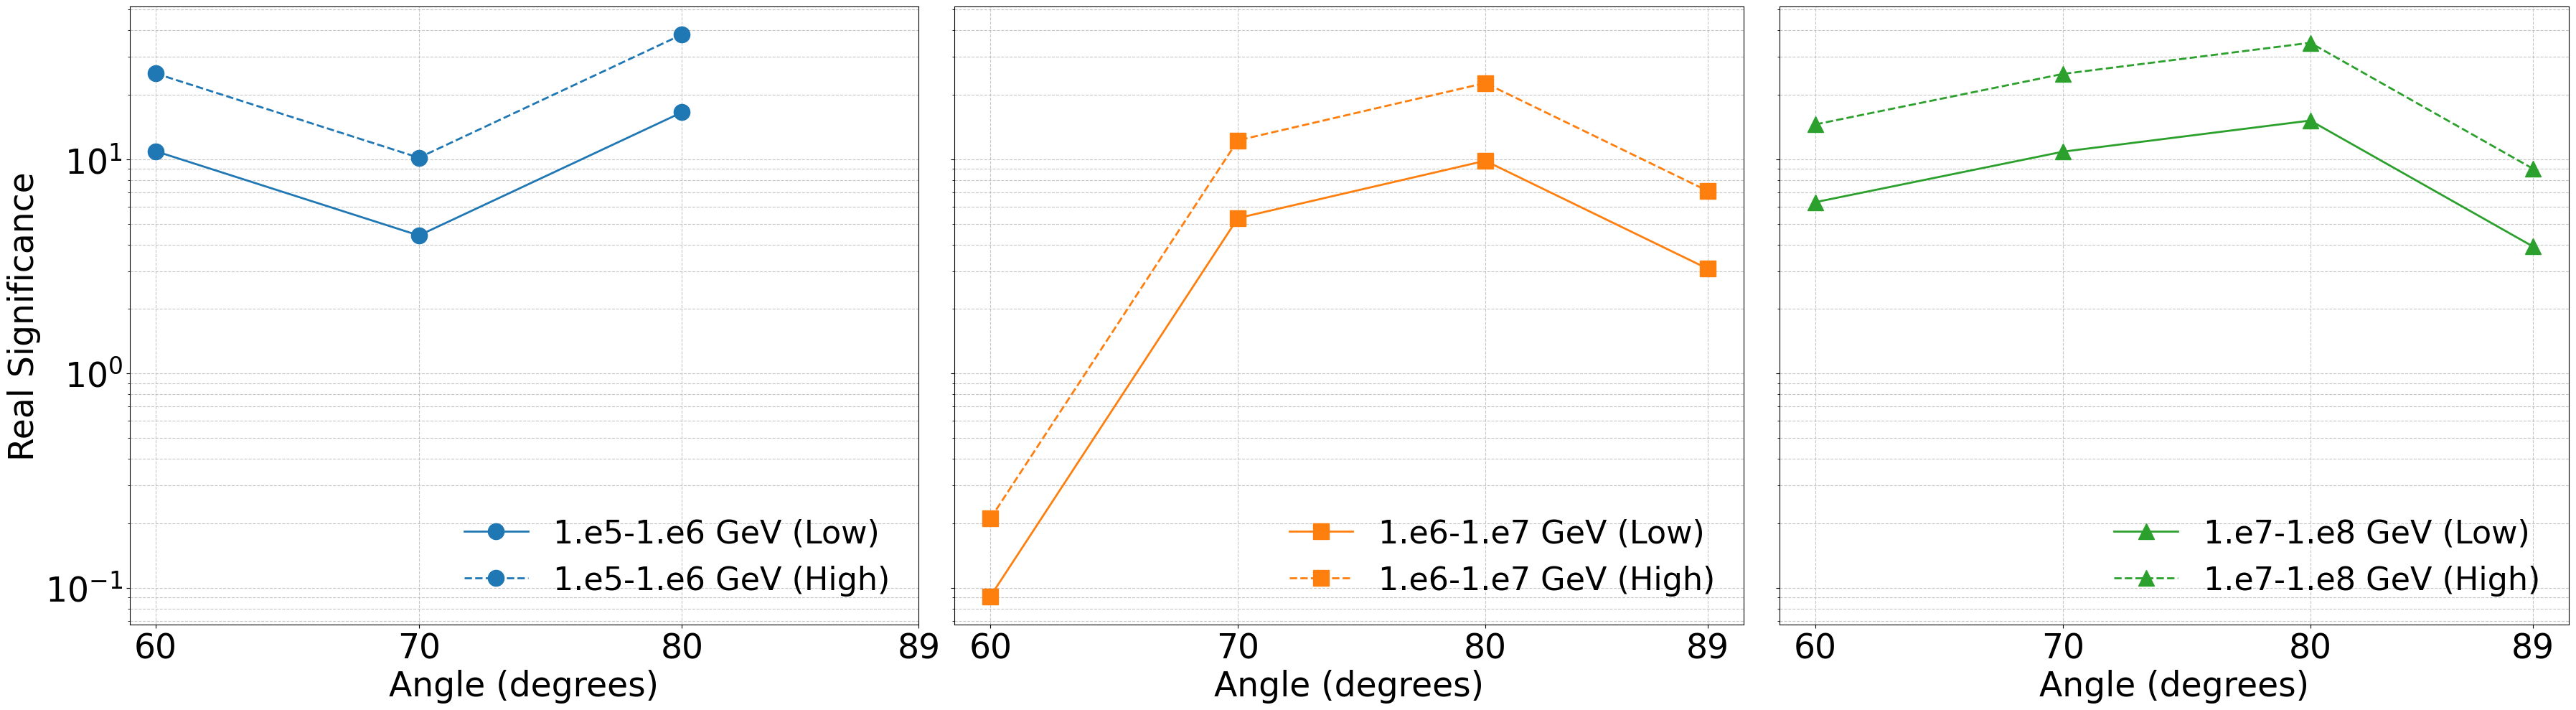

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read CSV file
df = pd.read_csv('./stacking_rf_svm_xgb_results_multifeature/summary_with_real_significance.csv')

# Extract angle information
df['angle'] = df['EnergyAngle'].str.split('-').str[-1].astype(int)

# Extract energy range information
def extract_energy_range(row):
    parts = row['EnergyAngle'].split('-')
    return f"{parts[0]}-{parts[1]}"

df['energy_range'] = df.apply(extract_energy_range, axis=1)

# Get unique energy ranges
energy_ranges = df['energy_range'].unique()
print(f"Energy ranges found: {energy_ranges}")

# Set colors and marker styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Different colors
markers = ['o', 's', '^', 'D']  # Different markers
line_styles = ['-', '--']  # Solid line for low, dashed line for high

# Create a figure with subplots (horizontal layout)
fig, axes = plt.subplots(nrows=1, ncols=len(energy_ranges), figsize=(12 * len(energy_ranges), 10), sharey=True)

# If there is only one subplot, axes is not an array, so convert it to an array
if len(energy_ranges) == 1:
    axes = [axes]

# Plot data for each energy range in separate subplots
for i, energy_range in enumerate(energy_ranges):
    subset = df[df['energy_range'] == energy_range]
    
    # Sort by angle
    subset = subset.sort_values('angle')
    
    # Plot Sig_epsilon_20_real_low
    axes[i].plot(subset['angle'], subset['Sig_epsilon_20_real_low'], 
                 label=f"{energy_range} GeV (Low)", 
                 color=colors[i], marker=markers[i], linestyle=line_styles[0], 
                 linewidth=2, markersize=16)
    
    # Plot Sig_epsilon_20_real_high
    axes[i].plot(subset['angle'], subset['Sig_epsilon_20_real_high'], 
                 label=f"{energy_range} GeV (High)", 
                 color=colors[i], marker=markers[i], linestyle=line_styles[1], 
                 linewidth=2, markersize=16)
    
    # Set y-axis to log scale
    axes[i].set_yscale('log')
    
    # Add legend (place it at the bottom right corner and remove the border)
    axes[i].legend(fontsize=32, loc='lower right', frameon=False)
    
    # Add grid
    axes[i].grid(True, which='both', linestyle='--', alpha=0.7)
    
    # Set x-axis label
    axes[i].set_xlabel('Angle (degrees)', fontsize=34)
    
    # Set y-axis label only for the first subplot
    if i == 0:
        axes[i].set_ylabel('Real Significance', fontsize=34)

# Set x-axis ticks
for ax in axes:
    ax.set_xticks([60, 70, 80, 89])
    ax.tick_params(axis='both', labelsize=34)

# Adjust layout
plt.tight_layout()

# Save the image
plt.savefig('./stacking_rf_svm_xgb_results_multifeature/significance_plot.png', dpi=800)
plt.savefig('./stacking_rf_svm_xgb_results_multifeature/significance_plot.pdf')

# Show the image
plt.show()